In [100]:
import cantera as ct  #importa a biblioteca de reações químicas Cantera
import numpy as np

from scipy.integrate import trapezoid #importa a biblioteca para integração numérica
import matplotlib.pyplot as plt #importa a biblioteca para construção de gráfico

from pandas import *
import pandas as pd


In [101]:
class InternalCombustionEngineSimulator:
    """
    A class for simulating an internal combustion engine using Cantera.
    
    This simulator models a complete engine cycle including intake, compression,
    combustion, and exhaust processes with valve timing and fuel injection.
    """
    
    def __init__(self, air_composition, rpm, displacement_volume, compression_ratio, piston_diameter, intake_temperature, intake_valve_open, intake_valve_close, intake_pressure):
        """
        Initialize the engine simulator with basic parameters.
        
        Args:
            air_composition (str): Composition of intake air
            rpm (float): Engine speed in revolutions per minute
            displacement_volume (float): Engine displacement volume in m³
            compression_ratio (float): Engine compression ratio
            piston_diameter (float): Piston diameter in m
        """
        # Core engine parameters
        self.air_composition = air_composition
        self.rpm = rpm
        self.frequency = rpm / 60 
        self.displacement_volume = displacement_volume
        self.compression_ratio = compression_ratio
        self.piston_diameter = piston_diameter
        self.intake_temperature = intake_temperature
        self.open = intake_valve_open
        self.close = intake_valve_close
        self.piston_area = 0.25 * np.pi * piston_diameter**2
        self.stroke = displacement_volume / self.piston_area
        self.intake_pressure = intake_pressure
        

        # Reaction parameters
        self.reaction_mechanism = 'nDodecane_Reitz.yaml'
        self.phase_name = 'nDodecane_IG'
        self.fuel_composition = 'c12h26:1'
        
        # Intake conditions
        self.intake_composition = self.air_composition
        
        # Exhaust conditions
        self.exhaust_pressure = 1.2e5  # Pa
        
        # Fuel injection parameters
        self.injector_temperature = 300.  # K
        self.injector_pressure = 1600e5  # Pa
        self.injector_composition = self.fuel_composition
        self.injector_mass = 3.2e-5  # kg/cycle
        
        # Ambient conditions
        self.ambient_temperature = 300.  # K
        self.ambient_pressure = 1e5  # Pa
        self.ambient_composition = self.air_composition
        
        # Valve timing (in radians)
        self.intake_timing = {
            'open': -self.open/ 180. * np.pi,
            'close': self.close / 180. * np.pi,
            'coefficient': 1.e-6
        }
        
        self.exhaust_timing = {
            'open': 522. / 180. * np.pi,
            'close': 18. / 180. * np.pi,
            'coefficient': 1.e-6
        }
        
        # Injection timing (in radians)
        self.injection_timing = {
            'start': 350.0 / 180.0 * np.pi,
            'end': 365.0 / 180.0 * np.pi
        }
        
        # Simulation parameters
        self.simulation_revolutions = 2
        self.max_temperature_step = 10.  # K
        self.relative_tolerance = 1.e-12
        self.absolute_tolerance = 1.e-16
        
        # Initialize simulation state storage
        self.states = None
        
    def setup_simulation(self):
        """
        Set up the Cantera reactor network for engine simulation.
        """
        # Remove os cálculos circulares e usa valores pré-calculados
        self.clearance_volume = self.displacement_volume / (self.compression_ratio - 1.0)


        # Setup gas and reactor
        gas = ct.Solution(self.reaction_mechanism, self.phase_name)
        gas.TPX = self.intake_temperature, self.intake_pressure, self.intake_composition
        
        # Create reactor and reservoirs
        self.cylinder = ct.IdealGasReactor(gas)
        self.cylinder.volume = self.clearance_volume
        
        # Setup inlet, outlet, and injector systems
        self._setup_inlet_system(gas)
        self._setup_outlet_system(gas)
        self._setup_injection_system(gas)
        self._setup_piston()
        
        # Create reactor network
        self.sim = ct.ReactorNet([self.cylinder])
        self.sim.rtol = self.relative_tolerance
        self.sim.atol = self.absolute_tolerance
        self.cylinder.set_advance_limit('temperature', self.max_temperature_step)
        
    def _setup_inlet_system(self, gas):
        """Setup inlet valve and reservoir."""
        inlet = ct.Reservoir(gas)
        self.inlet_valve = ct.Valve(inlet, self.cylinder)
        inlet_duration = np.mod(self.intake_timing['close'] - self.intake_timing['open'], 4 * np.pi)
        self.inlet_valve.valve_coeff = self.intake_timing['coefficient']
        self.inlet_valve.time_function = lambda t: np.mod(
            self._crank_angle(t) - self.intake_timing['open'], 4 * np.pi) < inlet_duration
            
    def _setup_outlet_system(self, gas):
        """Setup exhaust valve and reservoir."""
        gas.TPX = self.ambient_temperature, self.exhaust_pressure, self.ambient_composition
        outlet = ct.Reservoir(gas)
        self.outlet_valve = ct.Valve(self.cylinder, outlet)
        outlet_duration = np.mod(self.exhaust_timing['close'] - self.exhaust_timing['open'], 4 * np.pi)
        self.outlet_valve.valve_coeff = self.exhaust_timing['coefficient']
        self.outlet_valve.time_function = lambda t: np.mod(
            self._crank_angle(t) - self.exhaust_timing['open'], 4 * np.pi) < outlet_duration
            
    def _setup_injection_system(self, gas):
        """Setup fuel injector."""
        gas.TPX = self.injector_temperature, self.injector_pressure, self.injector_composition
        injector = ct.Reservoir(gas)
        self.injector = ct.MassFlowController(injector, self.cylinder)
        injection_duration = np.mod(self.injection_timing['end'] - self.injection_timing['start'], 4 * np.pi)
        injection_time = (self.injection_timing['end'] - self.injection_timing['start']) / (2 * np.pi * self.frequency)
        self.injector.mass_flow_coeff = self.injector_mass / injection_time
        self.injector.time_function = lambda t: np.mod(
            self._crank_angle(t) - self.injection_timing['start'], 4 * np.pi) < injection_duration
            
    def _setup_piston(self):
        """Setup piston as a moving wall."""
        gas = ct.Solution(self.reaction_mechanism, self.phase_name)
        gas.TPX = self.ambient_temperature, self.ambient_pressure, self.ambient_composition
        ambient = ct.Reservoir(gas)
        self.piston = ct.Wall(ambient, self.cylinder)
        self.piston.area = self.piston_area
        self.piston.velocity = self._piston_speed
        
    def _crank_angle(self, t):
        """Convert time to crank angle in radians."""
        return np.remainder(2 * np.pi * self.frequency * t, 4 * np.pi)
        
    def _piston_speed(self, t):
        """Calculate piston speed at time t."""
        return -self.stroke / 2 * 2 * np.pi * self.frequency * np.sin(self._crank_angle(t))
        
    def run_simulation(self):
        """
        Run the engine simulation for the specified number of revolutions.
        """
        # Setup solution array for storing results
        self.states = ct.SolutionArray(
            self.cylinder.thermo,
            extra=('t', 'ca', 'V', 'm', 'mdot_in', 'mdot_out', 'dWv_dt'),
        )
        
        # Calculate time steps
        crank_angle_step = 0.10  # degrees
        time_step = crank_angle_step / (360 * self.frequency)
        end_time = self.simulation_revolutions / self.frequency
        
        # Run simulation
        while self.sim.time < end_time:
            self.sim.advance(self.sim.time + time_step)
            
            # Calculate power
            power = -(self.cylinder.thermo.P - self.ambient_pressure) * \
                   self.piston_area * self._piston_speed(self.sim.time)
            
            # Store results
            self.states.append(
                self.cylinder.thermo.state,
                t=self.sim.time,
                ca=self._crank_angle(self.sim.time),
                V=self.cylinder.volume,
                m=self.cylinder.mass,
                mdot_in=self.inlet_valve.mass_flow_rate,
                mdot_out=self.outlet_valve.mass_flow_rate,
                dWv_dt=power
            )
            
    def plot_pressure_angle(self):
            """Plot pressure vs crank angle and store axes data."""
            if self.states is None or len(self.states.t) == 0:
                raise ValueError("Execute run_simulation() antes de chamar plot_pressure_angle().")

            # Armazenar ângulos e pressões corretamente na classe
            self.angles = self.states.t * 360 * self.frequency
            self.pressures = self.states.P / 1e5  # Convertendo para bar

            # Plota gráfico
            plt.figure(figsize=(10, 6))
            plt.plot(self.angles, self.pressures)
            plt.xlabel('Crank Angle [°]')
            plt.ylabel('Pressure [bar]')
            plt.grid(True)
            plt.xlim(0, self.simulation_revolutions * 360)
            plt.show()

    def save_eixos(self):
        """Save crank angle and pressure as NumPy arrays."""
        # Garante que os valores já foram gerados
        if not hasattr(self, 'angles') or not hasattr(self, 'pressures'):
            raise ValueError("Execute plot_pressure_angle() antes de chamar save_eixos().")

        array_x = np.array(self.angles)
        array_y = np.array(self.pressures)

        print(f'Array eixo x:\n{array_x}')
        print(f'Array eixo y:\n{array_y}')

        return array_x, array_y  # Retorna os arrays para uso posterior

        
    def plot_temperature_angle(self):
        """Plot temperature vs crank angle."""
        times = self.states.t
        angles = times * 360 * self.frequency
        plt.figure(figsize=(10, 6))
        plt.plot(angles, self.states.T)
        plt.xlabel('Crank Angle [°]')
        plt.ylabel('Temperature [K]')
        plt.grid(True)
        plt.show()

        
    def plot_pv_diagram(self):
        """Plot pressure-volume diagram."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.states.V * 1e6, self.states.P/1e5)
        plt.xlabel('Volume [cm³]')
        plt.ylabel('Pressure [bar]')
        plt.grid(True)
        plt.show()
        
    def calculate_performance(self):
        """
        Calculate and return key engine performance metrics.
        
        Returns:
            dict: Dictionary containing performance metrics
        """
        t = self.states.t
        
        # Calculate heat release
        Q = trapezoid(self.states.heat_release_rate * self.states.V, t)
        heat_release_rate = Q/t[-1]/1000.0  # kW
        
        # Calculate work
        W = trapezoid(self.states.dWv_dt, t)
        power = W/t[-1]/1000.0  # kW
        
        # Calculate efficiency
        efficiency = (W/Q) * 100.0  # %
        
        # Calculate emissions
        MW = self.states.mean_molecular_weight
        
        co_emission = trapezoid(MW * self.states.mdot_out * self.states('CO').X[:, 0], t)
        co_emission /= trapezoid(MW * self.states.mdot_out, t)
        co_ppm = co_emission * 1e6
        
        co2_emission = trapezoid(MW * self.states.mdot_out * self.states('CO2').X[:, 0], t)
        co2_emission /= trapezoid(MW * self.states.mdot_out, t)
        co2_ppm = co2_emission * 1e6
        
        # Maximum values
        p_max = np.max(self.states.P/1e5)  # bar
        T_max = np.max(self.states.T)  # K
        
        return {
            'heat_release_rate': heat_release_rate,
            'power': power,
            'efficiency': efficiency,
            'co_emissions': co_ppm,
            'co2_emissions': co2_ppm,
            'max_pressure': p_max,
            'max_temperature': T_max
        }

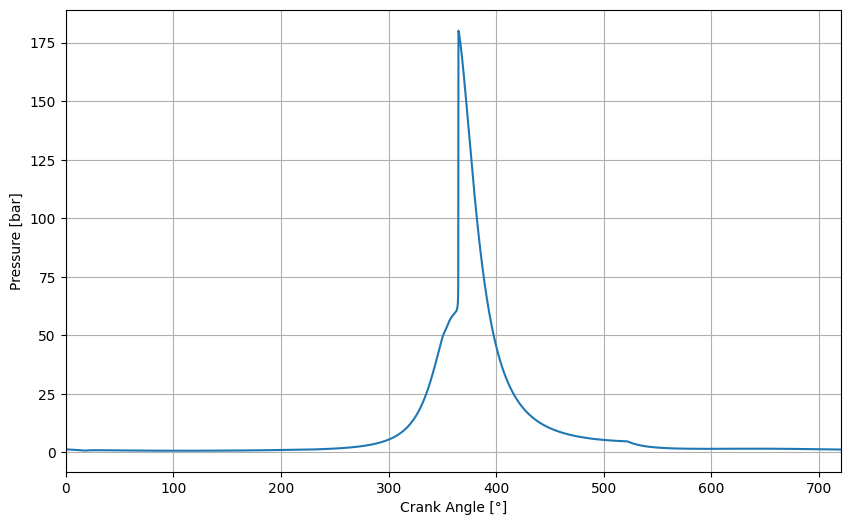

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19873878e+02
 7.19973878e+02 7.20073878e+02]
Array eixo y:
[1.29745273 1.2949193  1.29239958 ... 1.20725146 1.20670372 1.20615654]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 18.6 kW
Eficiência Térmica: 53.2%
Taxa de Liberação de Calor: 34.9 kW

Condições Máximas:
Pressão Máxima: 180.1 bar
Temperatura Máxima: 2881.3 K

Emissões:
CO: 3.9 ppm
CO2: 106698.0 ppm


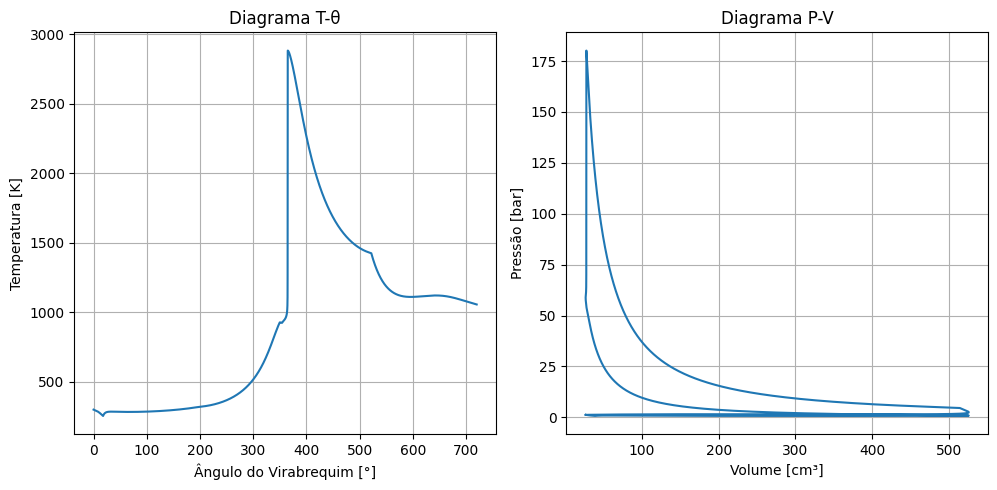

In [102]:
mci_1 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=3000,
    displacement_volume=0.5e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_1.setup_simulation()
mci_1.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_1.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
x_data, y_data = mci_1.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_1):
    metrics = mci_1.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_1.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_1.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_1.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_1.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_1.states.t * 360 * mci_1.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_1.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_1.states.V * 1e6, mci_1.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_1)

In [103]:
df_1 = pd.DataFrame({'Pressão': y_data, 'Ângulo': x_data})
df_1

,Pressão,Ângulo
0,1.297453,0.100000
1,1.294919,0.200000
2,1.292400,0.300000
3,1.289893,0.400000
4,1.287401,0.500000
...,...,...
7361,1.208349,719.673878
7362,1.207800,719.773878
7363,1.207251,719.873878
7364,1.206704,719.973878


#### Letra a)

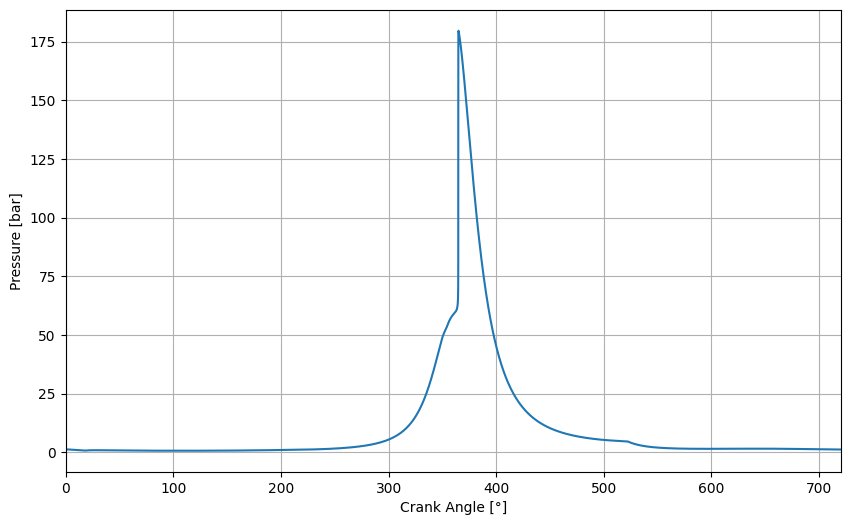

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19886768e+02
 7.19986768e+02 7.20086768e+02]
Array eixo y:
[1.2974458  1.29490585 1.29237998 ... 1.20714719 1.20660106 1.20605549]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 18.6 kW
Eficiência Térmica: 53.2%
Taxa de Liberação de Calor: 34.9 kW

Condições Máximas:
Pressão Máxima: 180.1 bar
Temperatura Máxima: 2881.3 K

Emissões:
CO: 3.9 ppm
CO2: 106698.0 ppm


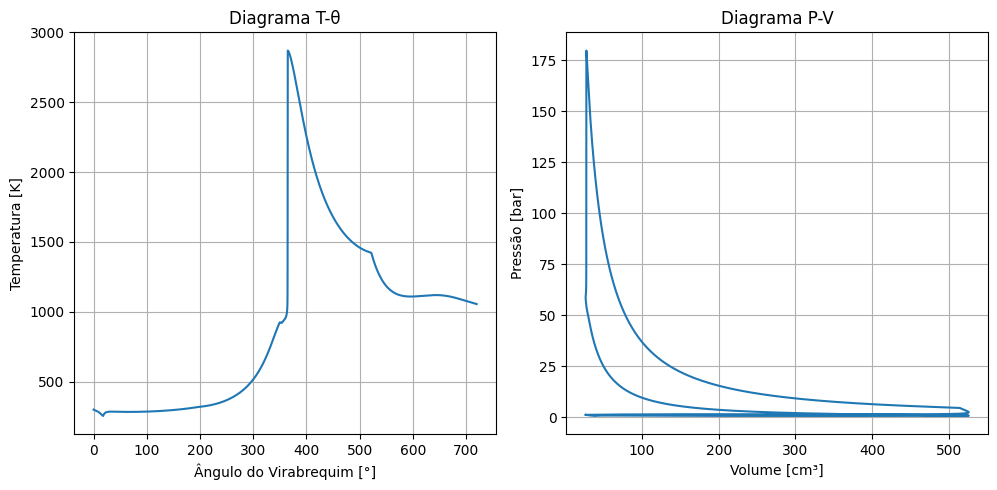

In [104]:
mci_a = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.74, h2o:0.048, co2:0.002',
    rpm=3000,
    displacement_volume=0.5e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_a.setup_simulation()
mci_a.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_a.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xa_data, ya_data = mci_a.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_a):
    metrics = mci_1.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_a.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_a.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_a.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_a.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_a.states.t * 360 * mci_a.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_a.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_a.states.V * 1e6, mci_a.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_a)

In [105]:
df_a = pd.DataFrame({'Pressão': ya_data, 'Ângulo': xa_data})
df_a.name = "Curva com ar alterado"
df_a

,Pressão,Ângulo
0,1.297446,0.100000
1,1.294906,0.200000
2,1.292380,0.300000
3,1.289868,0.400000
4,1.287370,0.500000
...,...,...
7387,1.208241,719.686768
7388,1.207694,719.786768
7389,1.207147,719.886768
7390,1.206601,719.986768


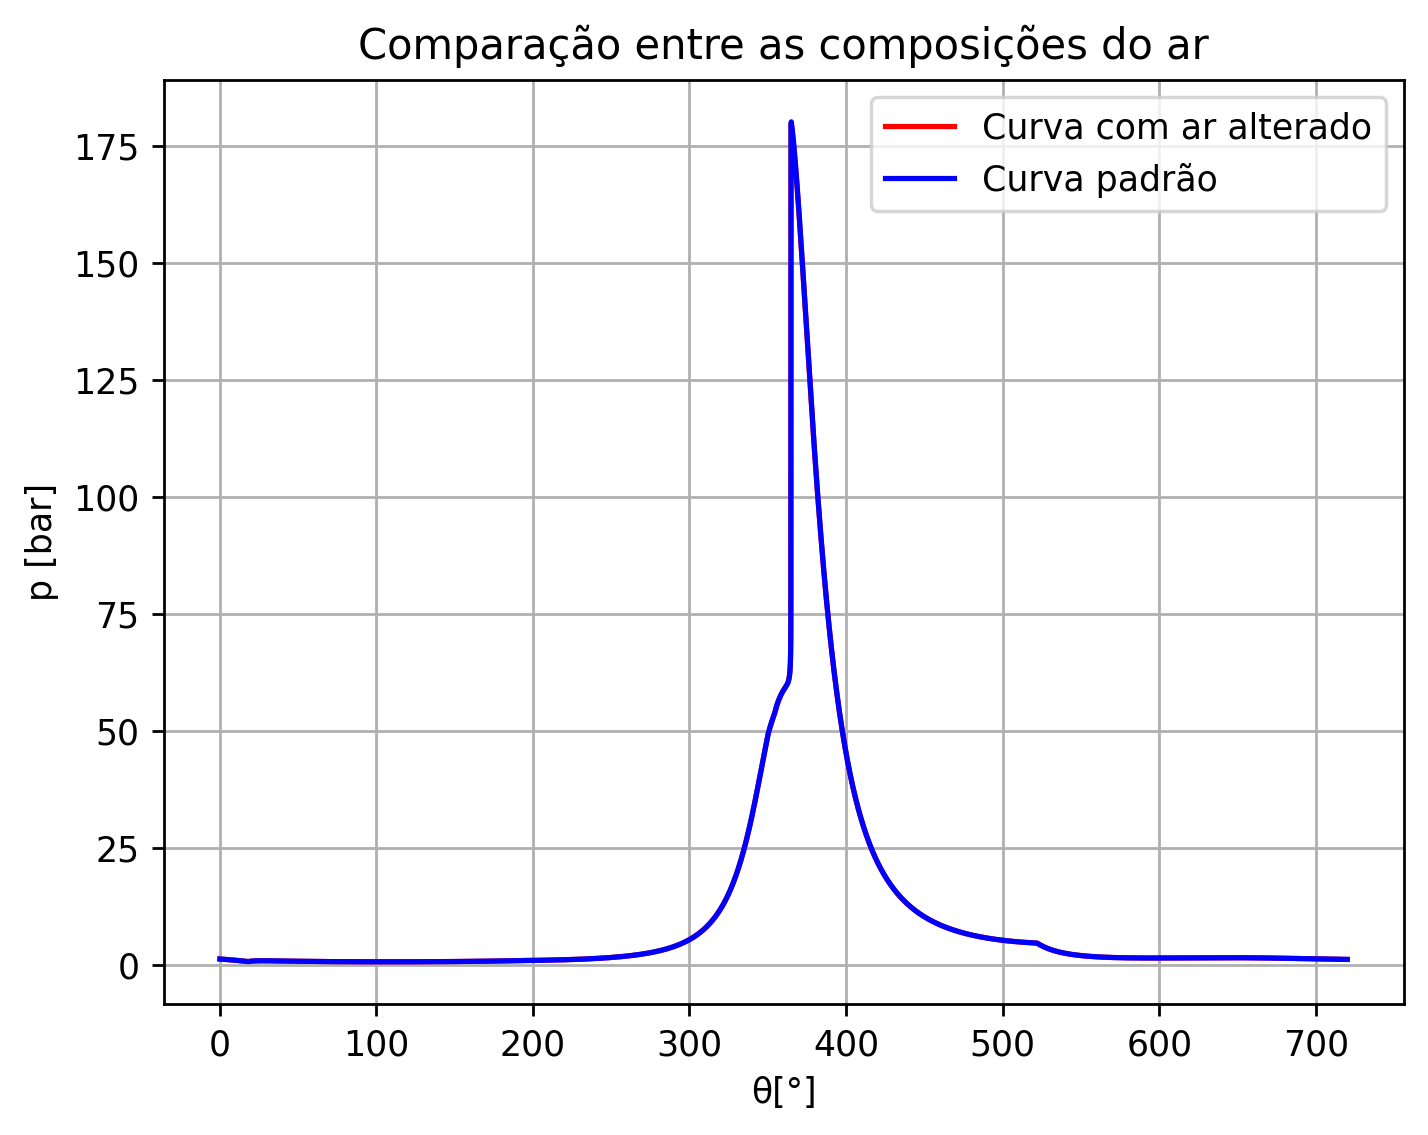

In [106]:
plt.figure(dpi=250)
plt.title('Comparação entre as composições do ar')
plt.xlabel('θ[°]')
plt.ylabel('p [bar]')
plt.plot(df_a['Ângulo'],df_a['Pressão'],color='red',label='Curva com ar alterado')
plt.plot(df_1['Ângulo'],df_1['Pressão'],color='blue',label='Curva padrão')
plt.legend()
plt.grid(True)
plt.savefig('composicao_ar.png', dpi=300, bbox_inches='tight')
plt.show()

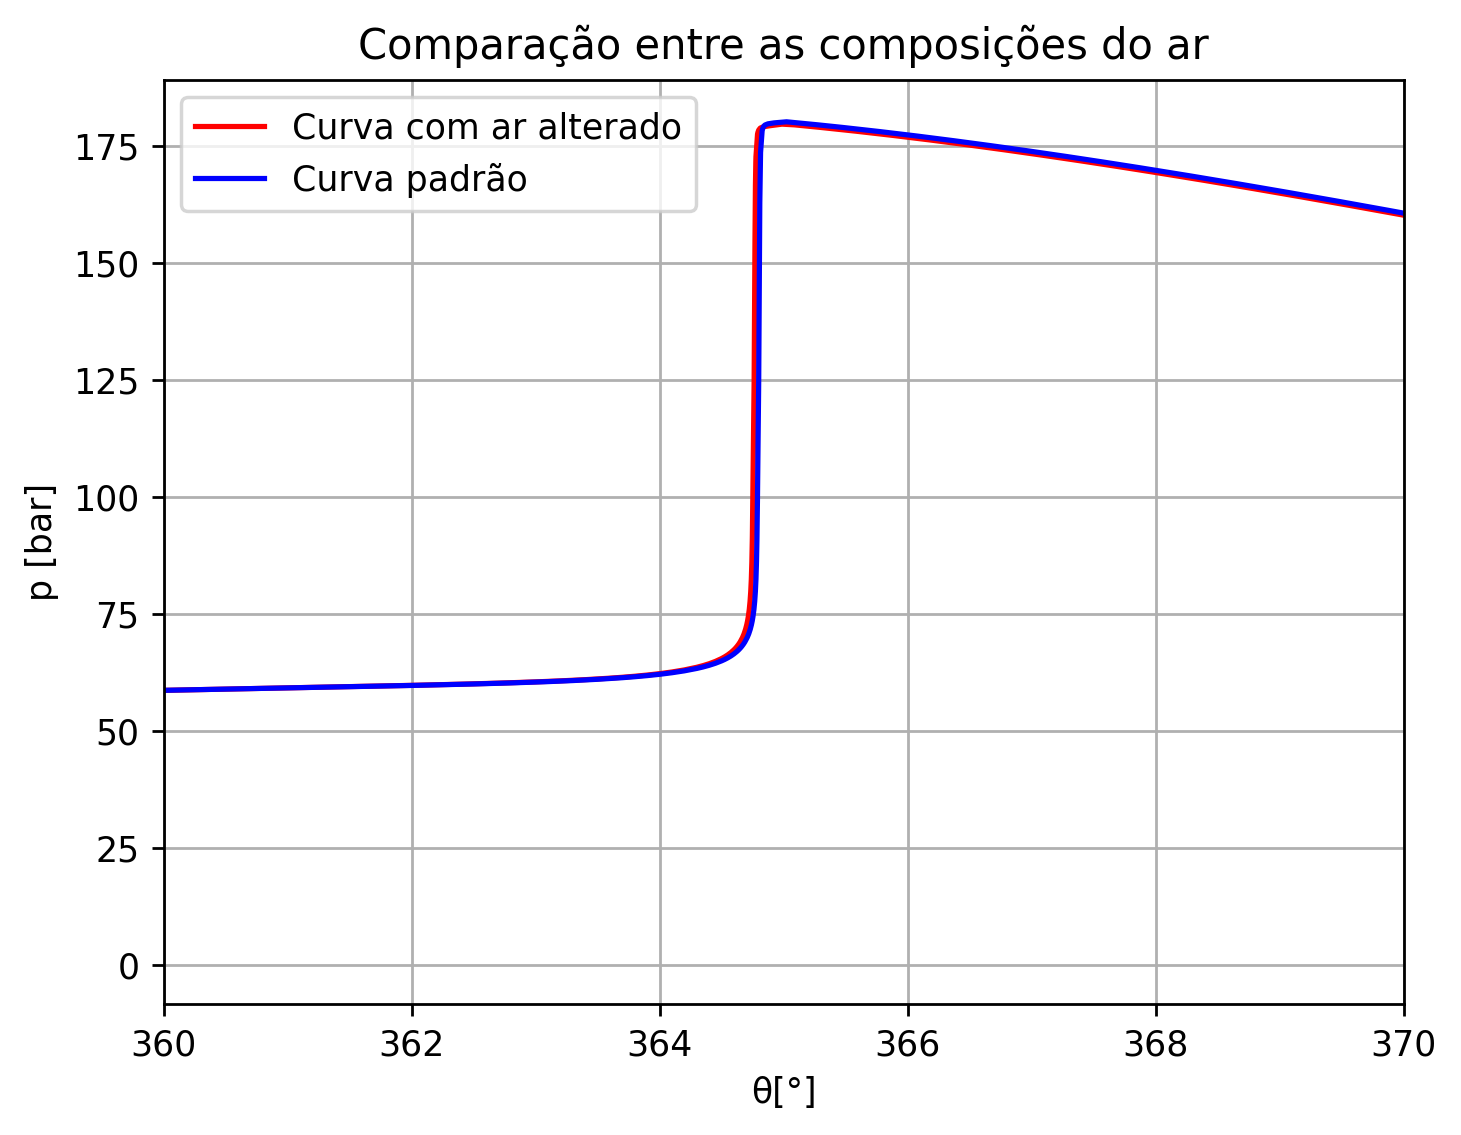

In [107]:
plt.figure(dpi=250)
plt.title('Comparação entre as composições do ar')
plt.xlabel('θ[°]')
plt.xlim(360,370)
plt.ylabel('p [bar]')
plt.plot(df_a['Ângulo'],df_a['Pressão'],color='red',label='Curva com ar alterado')
plt.plot(df_1['Ângulo'],df_1['Pressão'],color='blue',label='Curva padrão')
plt.legend()
plt.grid(True)
plt.savefig('composição_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

In [125]:
# Pequeno valor para evitar divisão por zero
epsilon = 1e-6  

# Criando a coluna de diferença percentual no df_a em relação ao df_1
df_a['Diferença %'] = np.abs(((df_a['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)

# Exibindo os resultados com título
print("\n===== Diferença Percentual de Pressão =====\n")
print("Curva com ar alterado")
print(df_a[(df_a['Ângulo'] >= 362) & (df_a['Ângulo'] <= 370)][['Ângulo', 'Diferença %']])


===== Diferença Percentual de Pressão =====

Curva com ar alterado
          Ângulo  Diferença %
3621  362.000050     0.030400
3622  362.100050     0.033319
3623  362.200050     0.036425
3624  362.300050     0.039742
3625  362.400050     0.043299
...          ...          ...
3886  369.586768     8.370498
3887  369.686768     8.430415
3888  369.786768     8.489740
3889  369.886768     8.548475
3890  369.986768     8.606625

[270 rows x 2 columns]


#### Letra B

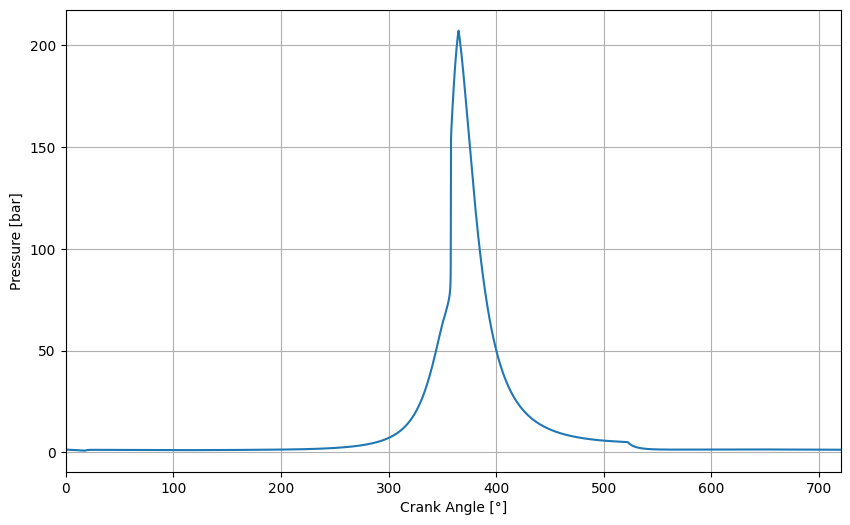

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19856448e+02
 7.19956448e+02 7.20056448e+02]
Array eixo y:
[1.2926037  1.28571282 1.27928863 ... 1.2014047  1.20118153 1.20095846]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 6.7 kW
Eficiência Térmica: 56.7%
Taxa de Liberação de Calor: 11.9 kW

Condições Máximas:
Pressão Máxima: 207.3 bar
Temperatura Máxima: 2601.1 K

Emissões:
CO: 0.1 ppm
CO2: 84365.2 ppm


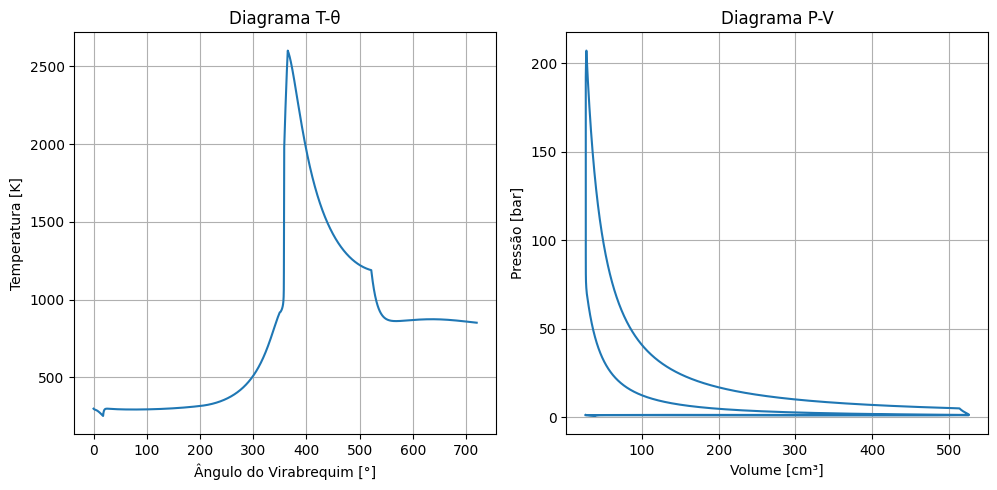

In [ ]:
#######################
# 1000 RPM
#######################


mci_b1 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=1000,
    displacement_volume=0.5e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_b1.setup_simulation()
mci_b1.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_b1.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xb1_data, yb1_data = mci_b1.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_b1):
    metrics = mci_b1.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_b1.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_b1.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_b1.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_b1.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_b1.states.t * 360 * mci_b1.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_b1.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_b1.states.V * 1e6, mci_b1.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_b1)

In [ ]:
df_b1 = pd.DataFrame({'Pressão': yb1_data, 'Ângulo': xb1_data})
df_b1

,Pressão,Ângulo
0,1.292604,0.100000
1,1.285713,0.200000
2,1.279289,0.300000
3,1.273296,0.400000
4,1.267701,0.500000
...,...,...
7320,1.201851,719.656448
7321,1.201628,719.756448
7322,1.201405,719.856448
7323,1.201182,719.956448


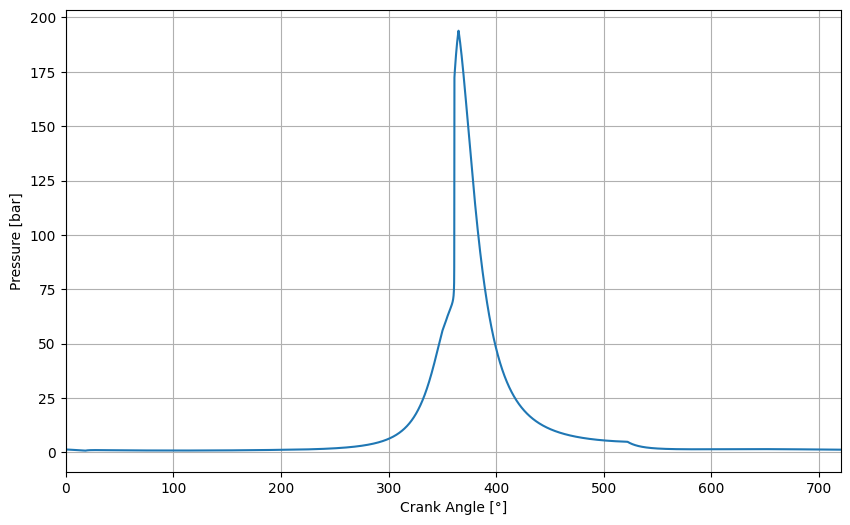

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19890638e+02
 7.19990638e+02 7.20090638e+02]
Array eixo y:
[1.29621669 1.29252715 1.28892796 ... 1.2040037  1.20359992 1.20319645]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 13.0 kW
Eficiência Térmica: 54.2%
Taxa de Liberação de Calor: 24.0 kW

Condições Máximas:
Pressão Máxima: 193.9 bar
Temperatura Máxima: 2750.2 K

Emissões:
CO: 0.7 ppm
CO2: 95044.1 ppm


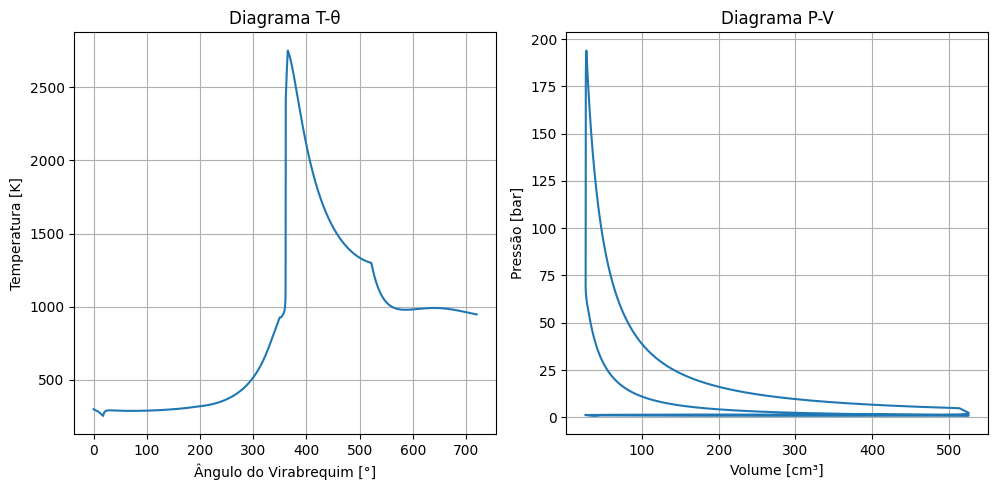

In [ ]:
#######################
# 2000 RPM
#######################


mci_b2 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=2000,
    displacement_volume=0.5e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_b2.setup_simulation()
mci_b2.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_b2.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xb2_data, yb2_data = mci_b2.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_b2):
    metrics = mci_b2.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_b2.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_b2.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_b2.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_b2.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_b2.states.t * 360 * mci_b2.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_b2.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_b2.states.V * 1e6, mci_b2.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_b2)

In [ ]:
df_b2 = pd.DataFrame({'Pressão': yb2_data, 'Ângulo': xb2_data})
df_b2

,Pressão,Ângulo
0,1.296217,0.100000
1,1.292527,0.200000
2,1.288928,0.300000
3,1.285416,0.400000
4,1.281988,0.500000
...,...,...
7323,1.204812,719.690638
7324,1.204408,719.790638
7325,1.204004,719.890638
7326,1.203600,719.990638


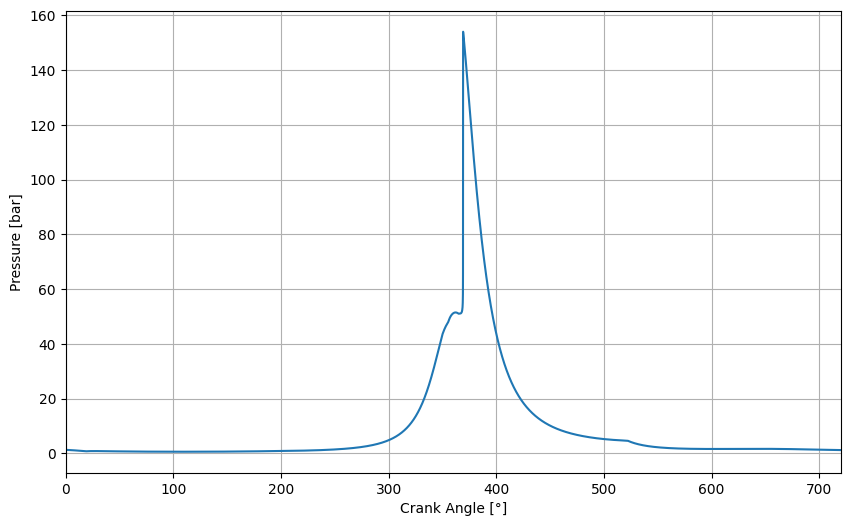

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19804444e+02
 7.19904444e+02 7.20004444e+02]
Array eixo y:
[1.29807681 1.29613894 1.29418686 ... 1.21080516 1.21014526 1.20948617]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 23.4 kW
Eficiência Térmica: 51.1%
Taxa de Liberação de Calor: 45.8 kW

Condições Máximas:
Pressão Máxima: 154.0 bar
Temperatura Máxima: 2960.8 K

Emissões:
CO: 44.0 ppm
CO2: 118664.0 ppm


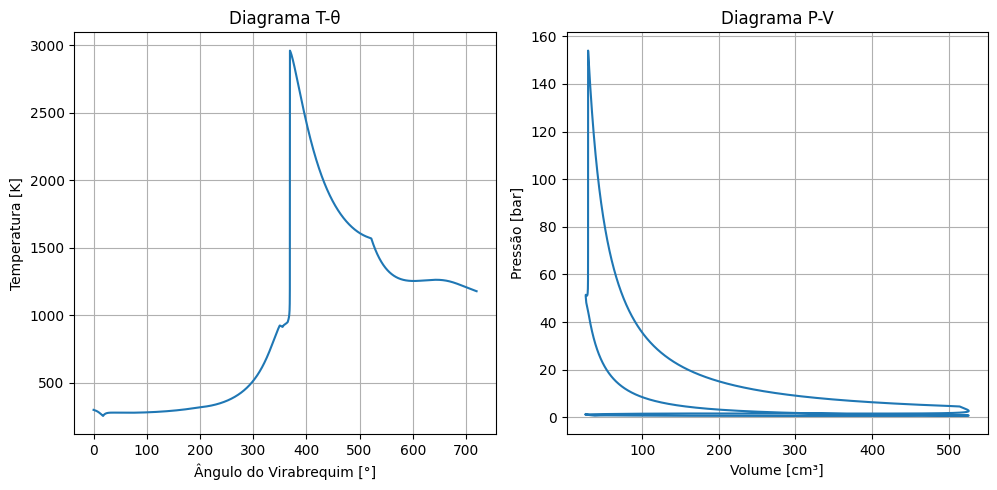

In [ ]:
#####################
# 4000 rpm
#####################

mci_b4 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=4000,
    displacement_volume=0.5e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_b4.setup_simulation()
mci_b4.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_b4.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xb4_data, yb4_data = mci_b4.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_b4):
    metrics = mci_b4.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_b4.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_b4.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_b4.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_b4.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_b4.states.t * 360 * mci_b4.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_b4.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_b4.states.V * 1e6, mci_b4.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_b4)

In [ ]:
df_b4 = pd.DataFrame({'Pressão': yb4_data, 'Ângulo': xb4_data})
df_b4

,Pressão,Ângulo
0,1.298077,0.100000
1,1.296139,0.200000
2,1.294187,0.300000
3,1.292221,0.400000
4,1.290242,0.500000
...,...,...
7384,1.212127,719.604444
7385,1.211466,719.704444
7386,1.210805,719.804444
7387,1.210145,719.904444


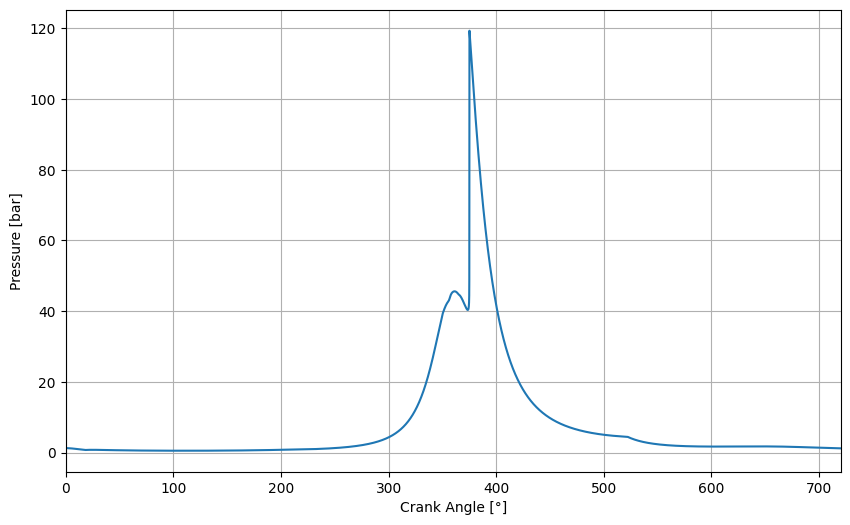

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19800391e+02
 7.19900391e+02 7.20000391e+02]
Array eixo y:
[1.29845322 1.29687839 1.2952761  ... 1.21446007 1.21368913 1.21291931]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 26.1 kW
Eficiência Térmica: 49.5%
Taxa de Liberação de Calor: 52.7 kW

Condições Máximas:
Pressão Máxima: 119.3 bar
Temperatura Máxima: 2982.3 K

Emissões:
CO: 9681.0 ppm
CO2: 119477.2 ppm


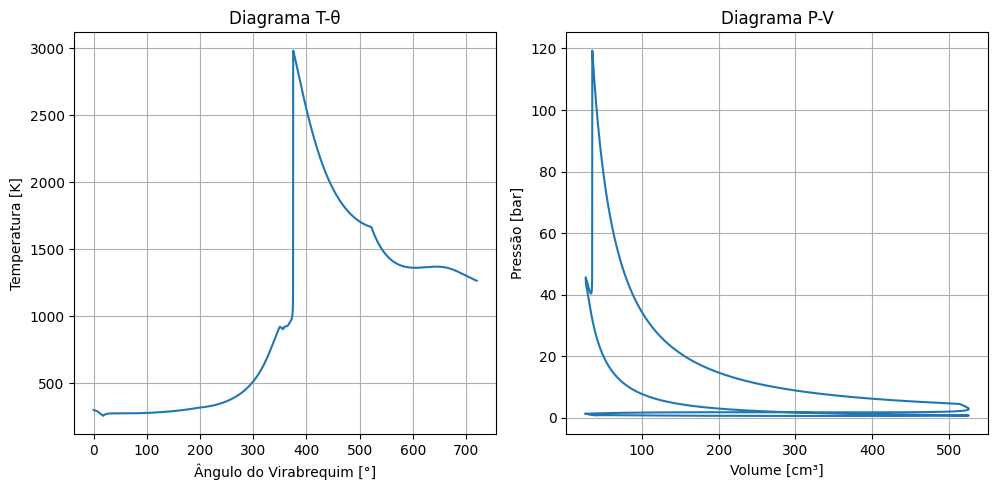

In [ ]:
#######################
# 5000 RPM
#######################


mci_b5 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=5000,
    displacement_volume=0.5e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_b5.setup_simulation()
mci_b5.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_b5.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xb5_data, yb5_data = mci_b5.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_b5):
    metrics = mci_b5.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_b5.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_b5.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_b5.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_b5.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_b5.states.t * 360 * mci_b5.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_b5.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_b5.states.V * 1e6, mci_b5.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_b5)

In [ ]:
df_b5 = pd.DataFrame({'Pressão': yb5_data, 'Ângulo': xb5_data})
df_b5

,Pressão,Ângulo
0,1.298453,0.100000
1,1.296878,0.200000
2,1.295276,0.300000
3,1.293647,0.400000
4,1.291992,0.500000
...,...,...
7348,1.216005,719.600391
7349,1.215232,719.700391
7350,1.214460,719.800391
7351,1.213689,719.900391


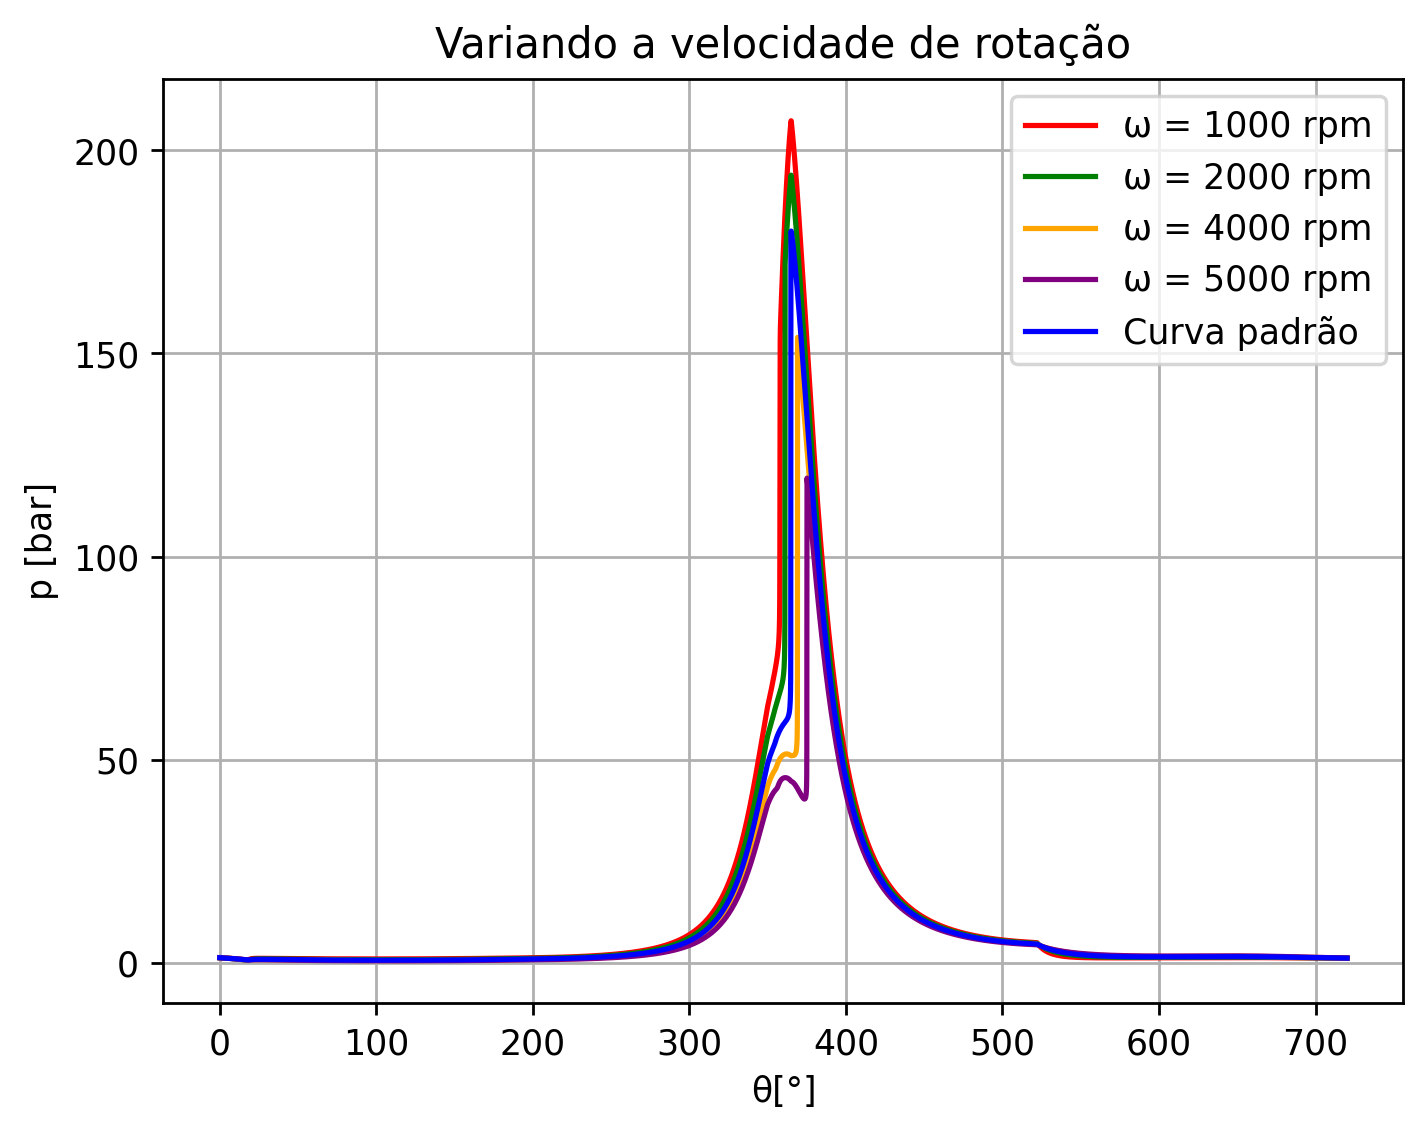

In [ ]:
plt.figure(dpi=250)
plt.title('Variando a velocidade de rotação')
plt.plot(df_b1['Ângulo'],df_b1['Pressão'],color='red',label='ω = 1000 rpm')
plt.plot(df_b2['Ângulo'],df_b2['Pressão'],color='green',label='ω = 2000 rpm')
plt.plot(df_b4['Ângulo'],df_b4['Pressão'],color='orange',label='ω = 4000 rpm')
plt.plot(df_b5['Ângulo'],df_b5['Pressão'],color='purple',label='ω = 5000 rpm')
plt.plot(df_1['Ângulo'],df_1['Pressão'],color='blue',label='Curva padrão')
plt.ylabel('p [bar]')
plt.xlabel('θ[°]')
plt.legend()
plt.grid(True)
plt.savefig('rot_varia.png', dpi=300, bbox_inches='tight')
plt.show()

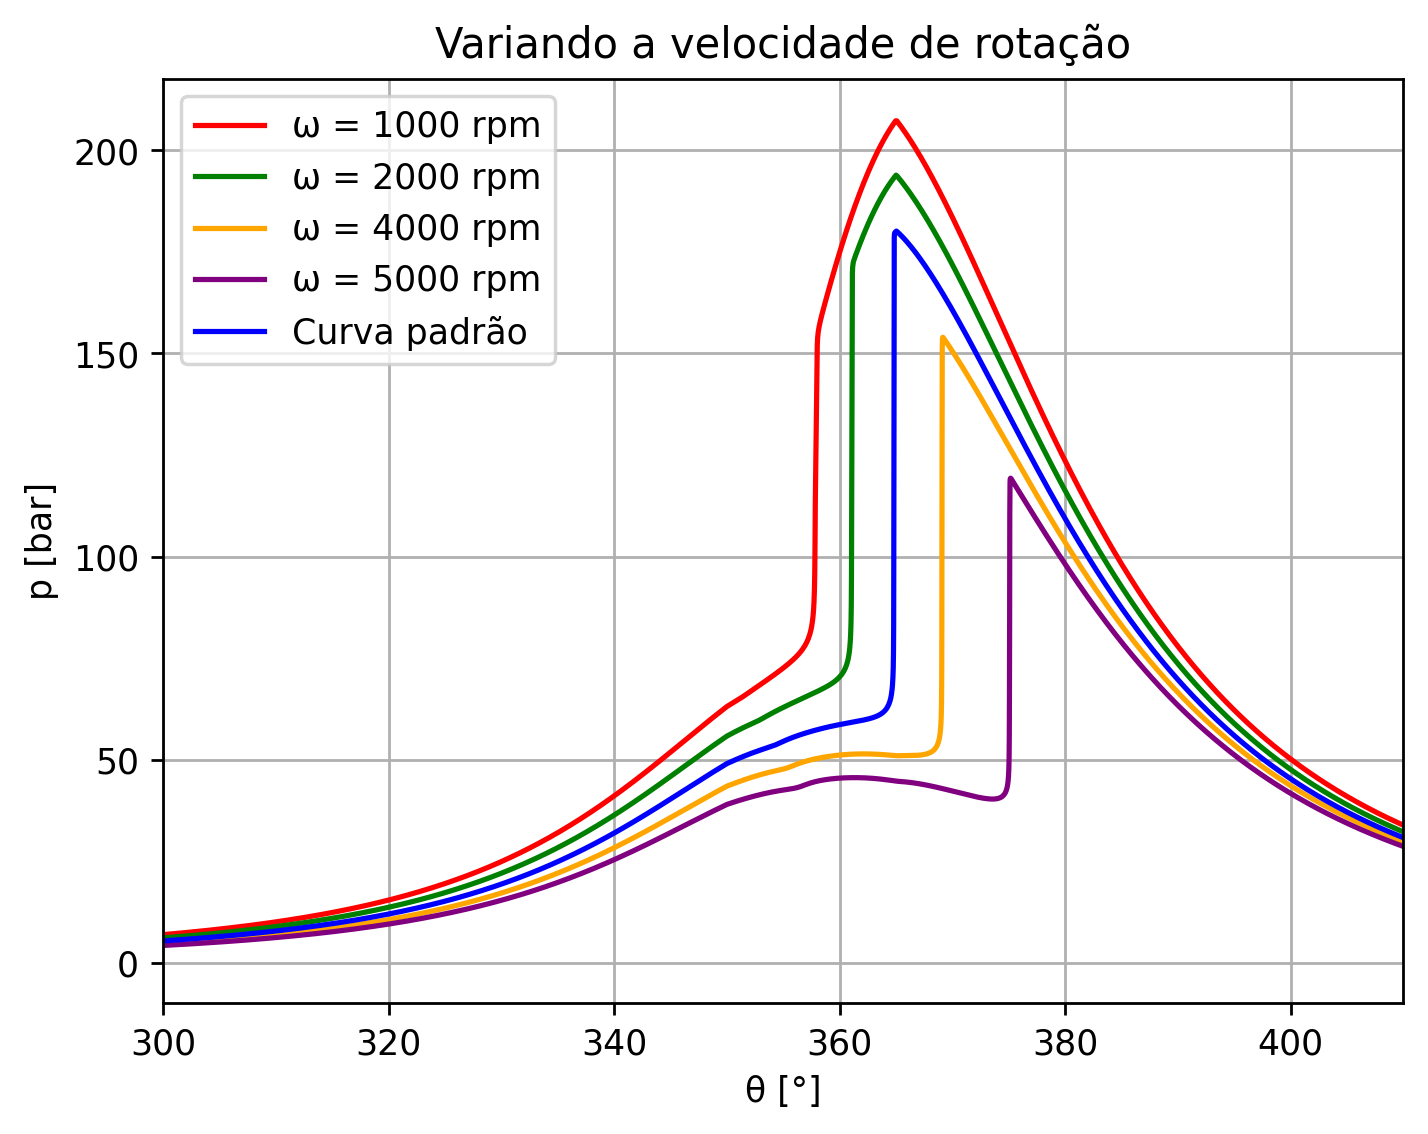

In [ ]:
plt.figure(dpi=250)
plt.title('Variando a velocidade de rotação')
plt.plot(df_b1['Ângulo'], df_b1['Pressão'], color='red', label='ω = 1000 rpm')
plt.plot(df_b2['Ângulo'], df_b2['Pressão'], color='green', label='ω = 2000 rpm')
plt.plot(df_b4['Ângulo'], df_b4['Pressão'], color='orange', label='ω = 4000 rpm')
plt.plot(df_b5['Ângulo'], df_b5['Pressão'], color='purple', label='ω = 5000 rpm')
plt.plot(df_1['Ângulo'], df_1['Pressão'], color='blue', label='Curva padrão')
plt.xlabel('θ [°]')
plt.ylabel('p [bar]')
plt.xlim(300, 410)
plt.legend()
plt.grid(True)
plt.savefig('rot_varia_zoom.png', dpi=300, bbox_inches='tight')
plt.show()


In [130]:
import numpy as np

# Pequeno valor para evitar divisão por zero
epsilon = 1e-6  

# Criando colunas de diferença percentual para cada curva em relação a df_1
df_b1['Diferença %'] = np.abs(((df_b1['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)
df_b2['Diferença %'] = np.abs(((df_b2['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)
df_b4['Diferença %'] = np.abs(((df_b4['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)
df_b5['Diferença %'] = np.abs(((df_b5['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)

# Definir o intervalo desejado de ângulos entre 362° e 370°
intervalo_b1 = (df_b1['Ângulo'] >= 362) & (df_b1['Ângulo'] <= 370)
intervalo_b2 = (df_b2['Ângulo'] >= 362) & (df_b2['Ângulo'] <= 370)
intervalo_b4 = (df_b4['Ângulo'] >= 362) & (df_b4['Ângulo'] <= 370)
intervalo_b5 = (df_b5['Ângulo'] >= 362) & (df_b5['Ângulo'] <= 370)

# Exibindo os resultados com título
print("\n===== Diferença Percentual de Pressão (Ângulos de 362° a 370°) =====\n")

print("ω = 1000 rpm")
print(df_b1[intervalo_b1][['Ângulo', 'Diferença %']], "\n")

print("ω = 2000 rpm")
print(df_b2[intervalo_b2][['Ângulo', 'Diferença %']], "\n")

print("ω = 4000 rpm")
print(df_b4[intervalo_b4][['Ângulo', 'Diferença %']], "\n")

print("ω = 5000 rpm")
print(df_b5[intervalo_b5][['Ângulo', 'Diferença %']], "\n")



===== Diferença Percentual de Pressão (Ângulos de 362° a 370°) =====

ω = 1000 rpm
          Ângulo  Diferença %
3744  362.056448    76.730216
3745  362.156448    76.688069
3746  362.256448    76.638200
3747  362.356448    76.579796
3748  362.456448    76.511985
...          ...          ...
3819  369.556448     3.926209
3820  369.656448     3.779308
3821  369.756448     3.634834
3822  369.856448     3.492679
3823  369.956448     3.352743

[80 rows x 2 columns] 

ω = 2000 rpm
          Ângulo  Diferença %
3747  362.090638    63.391122
3748  362.190638    63.384757
3749  362.290638    63.366621
3750  362.390638    63.335854
3751  362.490638    63.291558
...          ...          ...
3822  369.590638     2.313962
3823  369.690638     2.436319
3824  369.790638     2.556721
3825  369.890638     2.675249
3826  369.990638     2.791980

[80 rows x 2 columns] 

ω = 4000 rpm
          Ângulo  Diferença %
3621  362.000050    13.843589
3622  362.100050    13.926247
3623  362.200050    14.013602


#### Letra c

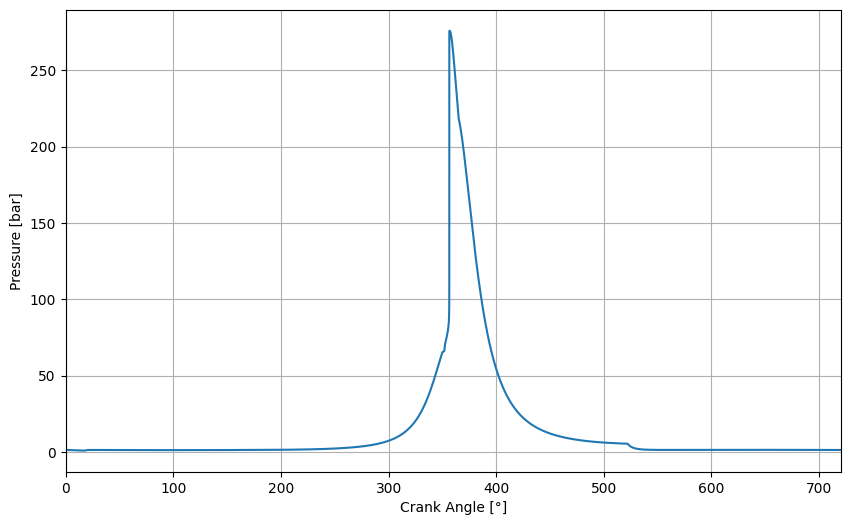

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19859912e+02
 7.19959912e+02 7.20059912e+02]
Array eixo y:
[1.28800053 1.27741393 1.2680637  ... 1.20075313 1.20059575 1.20043842]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 100.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 23.9 mm

Performance:
Potência por Cilindro: 18.6 kW
Eficiência Térmica: 53.2%
Taxa de Liberação de Calor: 34.9 kW

Condições Máximas:
Pressão Máxima: 180.1 bar
Temperatura Máxima: 2881.3 K

Emissões:
CO: 3.9 ppm
CO2: 106698.0 ppm


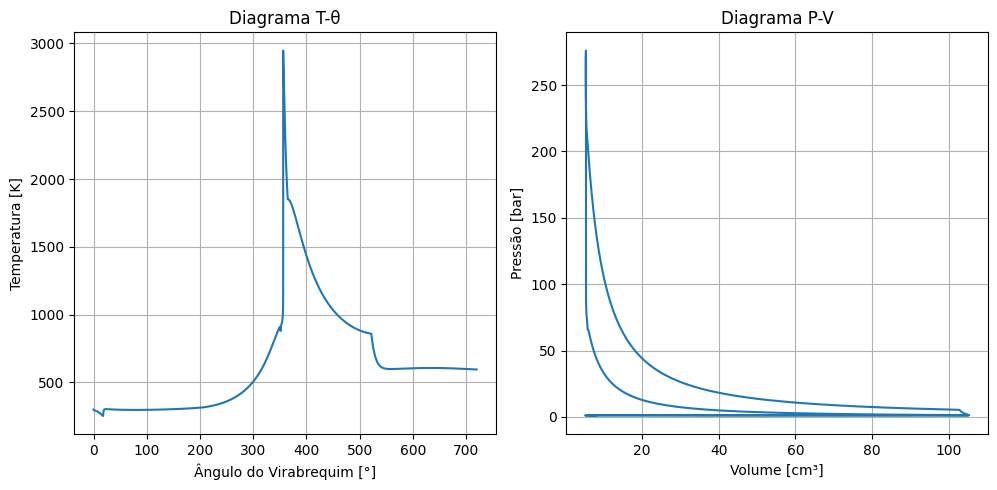

In [ ]:
############################
# V_h = .1e-3
############################

mci_c1 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=3000,
    displacement_volume=0.1e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_c1.setup_simulation()
mci_c1.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_c1.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xc1_data, yc1_data = mci_c1.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_c1):
    metrics = mci_1.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_c1.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_c1.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_c1.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_c1.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_c1.states.t * 360 * mci_c1.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_c1.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_c1.states.V * 1e6, mci_c1.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_c1)

In [ ]:
df_c1 = pd.DataFrame({'Pressão': yc1_data, 'Ângulo': xc1_data})
df_c1

,Pressão,Ângulo
0,1.288001,0.100000
1,1.277414,0.200000
2,1.268064,0.300000
3,1.259796,0.400000
4,1.252478,0.500000
...,...,...
7389,1.201068,719.659912
7390,1.200911,719.759912
7391,1.200753,719.859912
7392,1.200596,719.959912


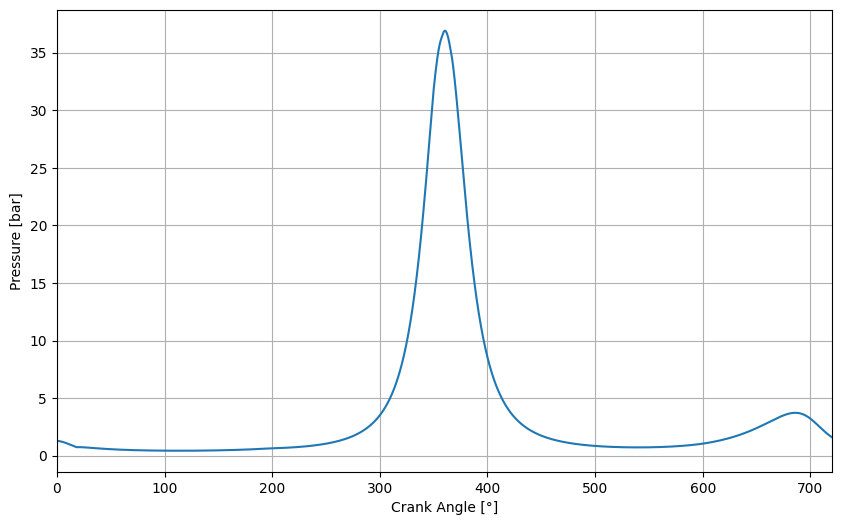

Array eixo x:
[1.0000000e-01 2.0000000e-01 3.0000000e-01 ... 7.1981255e+02 7.1991255e+02
 7.2001255e+02]
Array eixo y:
[1.29891528 1.29779005 1.29662486 ... 1.61991202 1.61376092 1.60764367]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 1200.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 286.7 mm

Performance:
Potência por Cilindro: -3.3 kW
Eficiência Térmica: -182.1%
Taxa de Liberação de Calor: 1.8 kW

Condições Máximas:
Pressão Máxima: 36.9 bar
Temperatura Máxima: 918.5 K

Emissões:
CO: 6803.6 ppm
CO2: 92.4 ppm


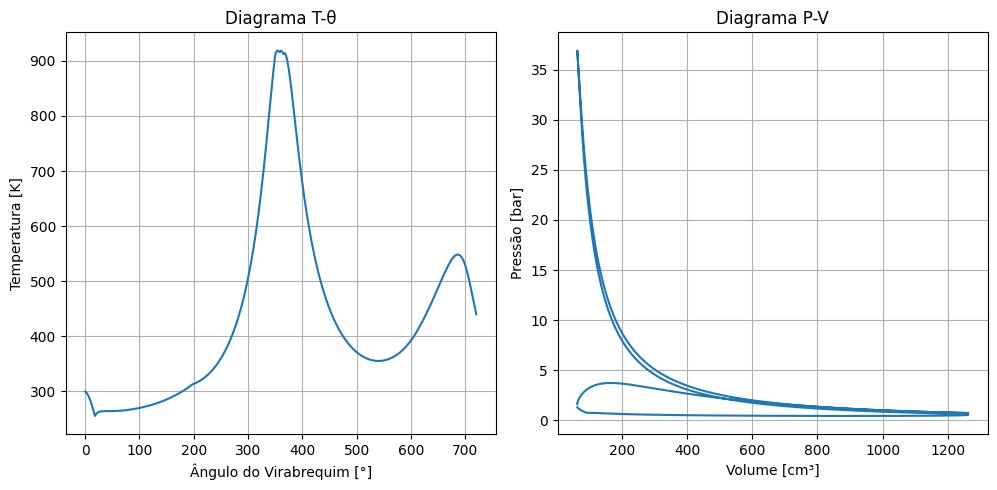

In [ ]:
############################
# V_h = 1.2e-3
############################

mci_c2 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=3000,
    displacement_volume=1.2e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_c2.setup_simulation()
mci_c2.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_c2.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xc2_data, yc2_data = mci_c2.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_c2):
    metrics = mci_c2.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_c2.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_c2.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_c2.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_c2.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_c2.states.t * 360 * mci_c2.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_c2.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_c2.states.V * 1e6, mci_c2.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_c2)

In [ ]:
df_c2 = pd.DataFrame({'Pressão': yc2_data, 'Ângulo': xc2_data})
df_c2

,Pressão,Ângulo
0,1.298915,0.10000
1,1.297790,0.20000
2,1.296625,0.30000
3,1.295420,0.40000
4,1.294177,0.50000
...,...,...
7198,1.632316,719.61255
7199,1.626097,719.71255
7200,1.619912,719.81255
7201,1.613761,719.91255


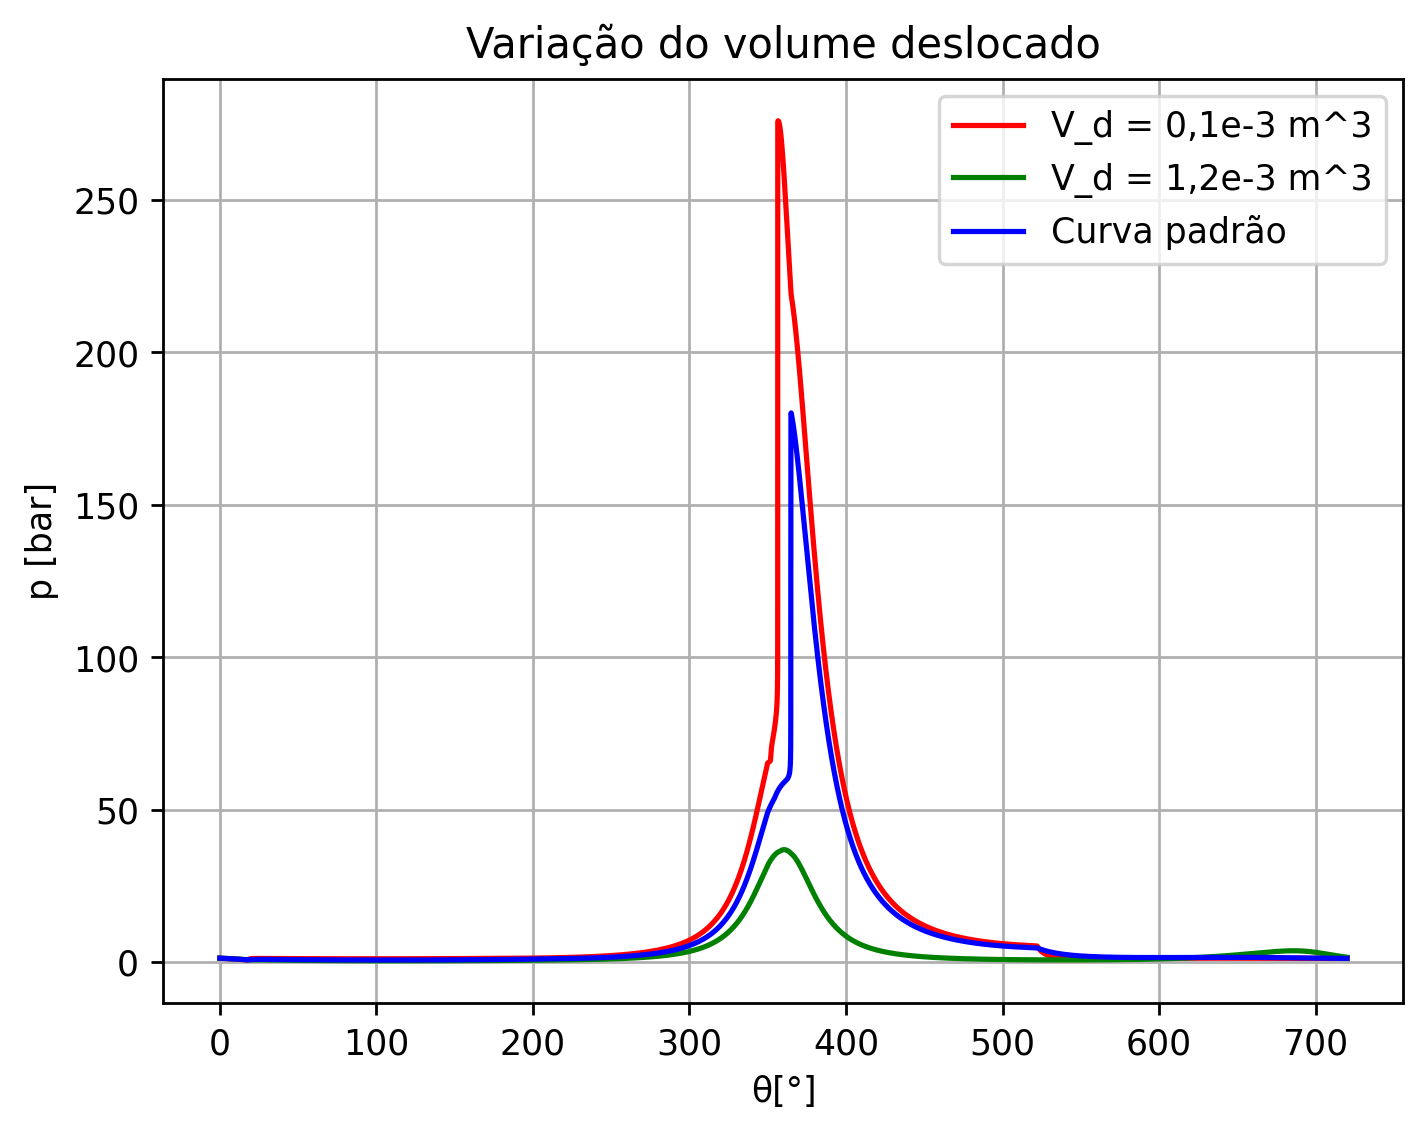

In [ ]:
plt.figure(dpi=250)
plt.title('Variação do volume deslocado')
plt.plot(df_c1['Ângulo'],df_c1['Pressão'],color='red',label='V_d = 0,1e-3 m^3')
plt.plot(df_c2['Ângulo'],df_c2['Pressão'],color='green',label='V_d = 1,2e-3 m^3')
plt.plot(df_1['Ângulo'],df_1['Pressão'],color='blue',label='Curva padrão')
plt.ylabel('p [bar]')
plt.xlabel('θ[°]')
plt.legend()
plt.grid(True)
plt.savefig('vd_varia.png', dpi=300, bbox_inches='tight')
plt.show()

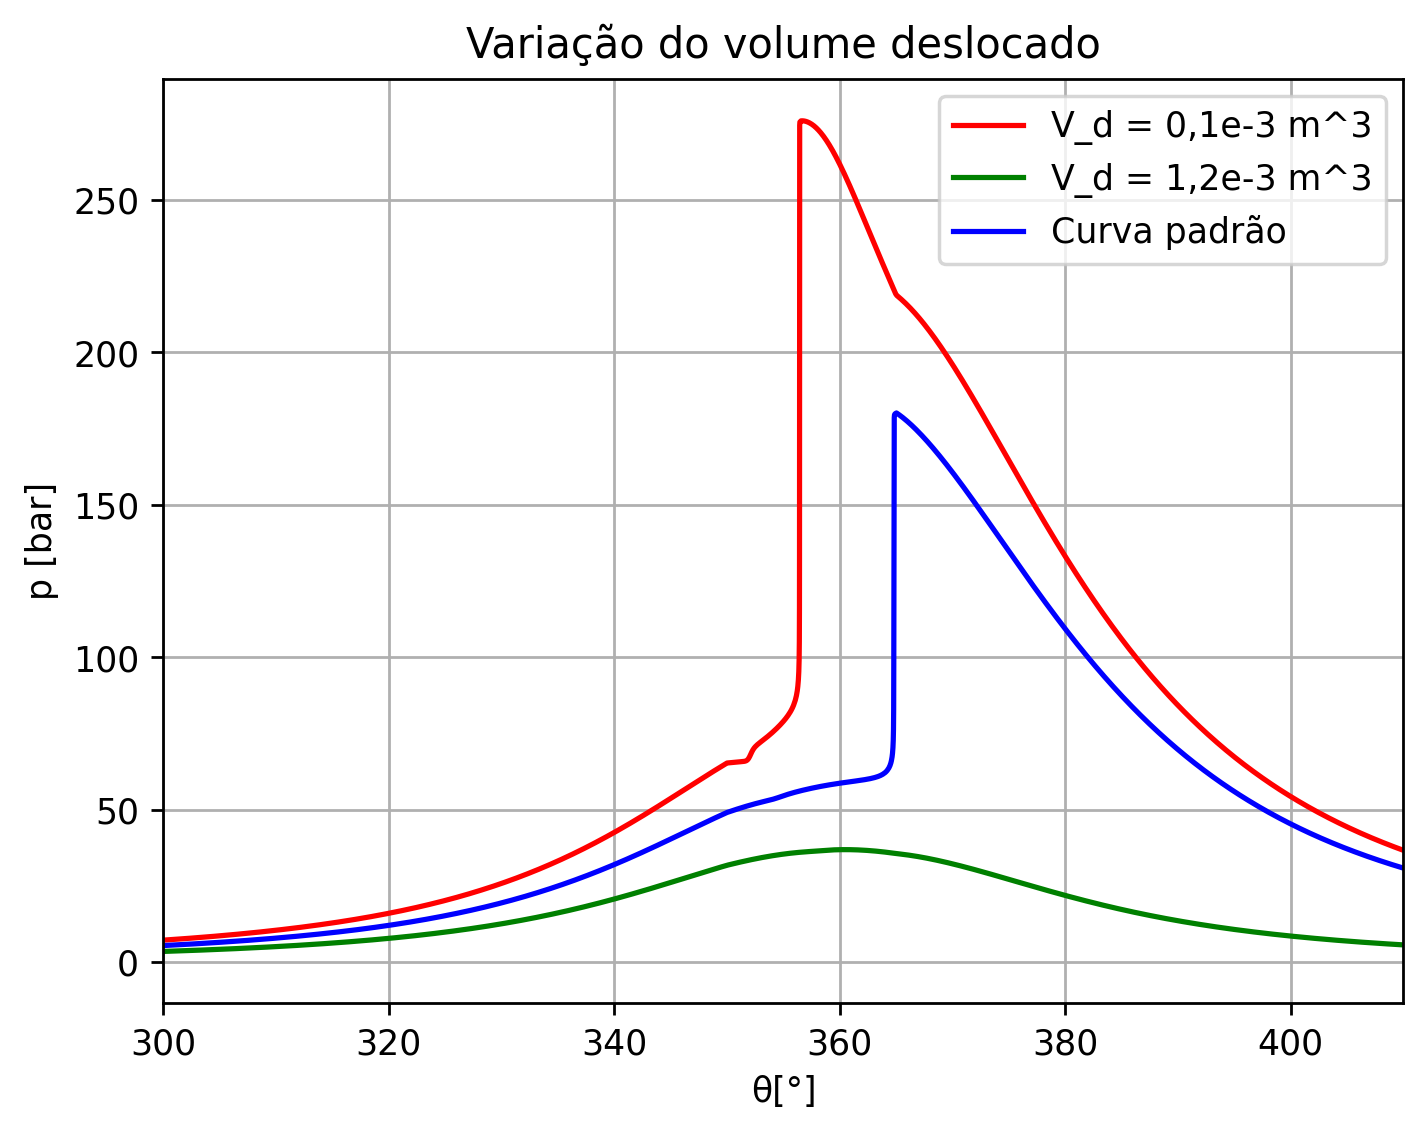

In [ ]:
plt.figure(dpi=250)
plt.title('Variação do volume deslocado')
plt.plot(df_c1['Ângulo'],df_c1['Pressão'],color='red',label='V_d = 0,1e-3 m^3')
plt.plot(df_c2['Ângulo'],df_c2['Pressão'],color='green',label='V_d = 1,2e-3 m^3')
plt.plot(df_1['Ângulo'],df_1['Pressão'],color='blue',label='Curva padrão')
plt.ylabel('p [bar]')
plt.xlabel('θ[°]')
plt.xlim(300, 410)
plt.legend()
plt.grid(True)
plt.savefig('vd_varia_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

In [131]:
# Pequeno valor para evitar divisão por zero
epsilon = 1e-6  

# Criando colunas de diferença percentual para cada curva em relação a df_1
df_c1['Diferença %'] = np.abs(((df_c1['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)
df_c2['Diferença %'] = np.abs(((df_c2['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)

# Filtrando apenas os valores no intervalo de 362° a 370°
intervalo_c1 = (df_c1['Ângulo'] >= 362) & (df_c1['Ângulo'] <= 370)
intervalo_c2 = (df_c2['Ângulo'] >= 362) & (df_c2['Ângulo'] <= 370)

# Exibindo os resultados com título
print("\n===== Diferença Percentual de Pressão (Ângulos de 362° a 370°) =====\n")

print("Caso V_d = 0,1 × 10⁻³ m³")
print(df_c1[intervalo_c1][['Ângulo', 'Diferença %']], "\n")

print("Caso V_d = 1,2 × 10⁻³ m³")
print(df_c2[intervalo_c2][['Ângulo', 'Diferença %']], "\n")


===== Diferença Percentual de Pressão (Ângulos de 362° a 370°) =====

Caso V_d = 0,1 × 10⁻³ m³
          Ângulo  Diferença %
3809  362.009912    37.144410
3810  362.059912    36.543476
3811  362.109912    35.978278
3812  362.159912    35.531654
3813  362.209912    35.130912
...          ...          ...
3888  369.559912    33.578846
3889  369.659912    33.668140
3890  369.759912    33.756320
3891  369.859912    33.843391
3892  369.959912    33.929359

[84 rows x 2 columns] 

Caso V_d = 1,2 × 10⁻³ m³
         Ângulo  Diferença %
3621  362.00005    38.492491
3622  362.10005    38.587346
3623  362.20005    38.686053
3624  362.30005    38.788903
3625  362.40005    38.896231
...         ...          ...
3697  369.51255    62.467749
3698  369.61255    62.769639
3699  369.71255    63.078487
3700  369.81255    63.394439
3701  369.91255    63.717608

[81 rows x 2 columns] 



#### Letra d

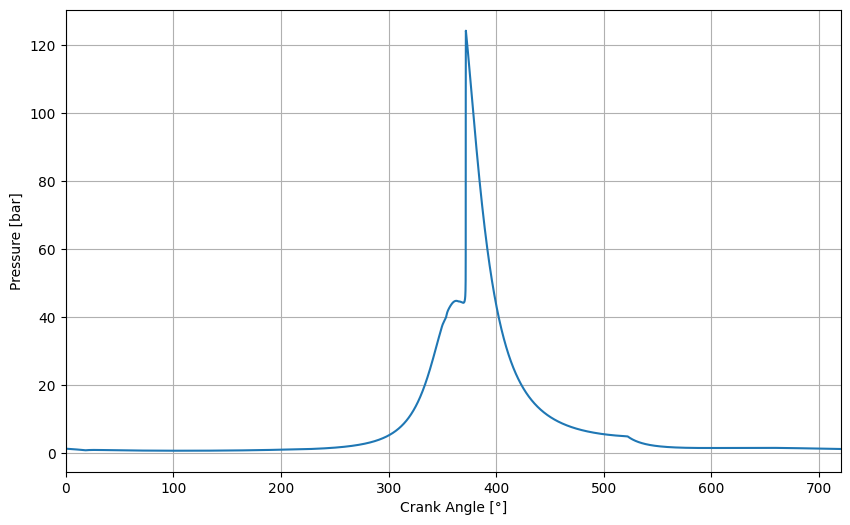

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19844141e+02
 7.19944141e+02 7.20044141e+02]
Array eixo y:
[1.2979835  1.29596712 1.29395099 ... 1.2085231  1.20799547 1.20746834]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 16.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 17.1 kW
Eficiência Térmica: 44.6%
Taxa de Liberação de Calor: 38.4 kW

Condições Máximas:
Pressão Máxima: 124.3 bar
Temperatura Máxima: 2782.4 K

Emissões:
CO: 5.4 ppm
CO2: 104734.7 ppm


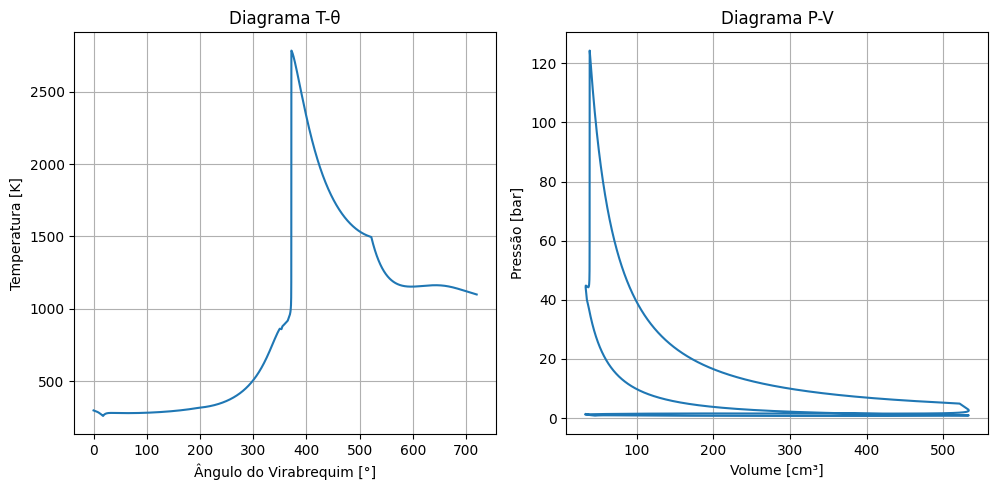

In [ ]:
############################
# RC = 16
############################

mci_d1 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=3000,
    displacement_volume=0.5e-3,
    compression_ratio=16,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_d1.setup_simulation()
mci_d1.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_d1.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xd1_data, yd1_data = mci_d1.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_d1):
    metrics = mci_d1.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_d1.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_d1.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_d1.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_d1.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_d1.states.t * 360 * mci_d1.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_d1.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_d1.states.V * 1e6, mci_d1.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_d1)

In [ ]:
df_d1 = pd.DataFrame({'Pressão': yd1_data, 'Ângulo': xd1_data})
df_d1

,Pressão,Ângulo
0,1.297983,0.100000
1,1.295967,0.200000
2,1.293951,0.300000
3,1.291935,0.400000
4,1.289920,0.500000
...,...,...
7326,1.209580,719.644141
7327,1.209051,719.744141
7328,1.208523,719.844141
7329,1.207995,719.944141


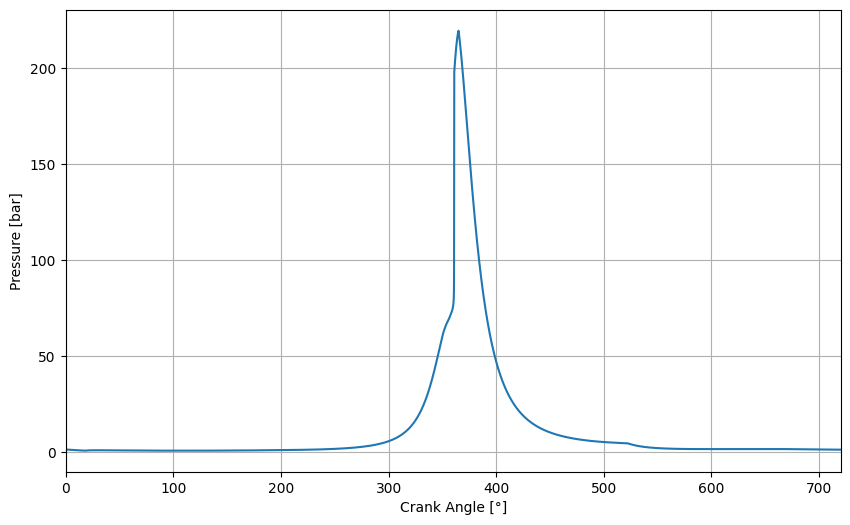

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19834375e+02
 7.19934375e+02 7.20034375e+02]
Array eixo y:
[1.29692485 1.29388287 1.2908733  ... 1.20653251 1.20597536 1.2054188 ]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 24.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 19.6 kW
Eficiência Térmica: 56.9%
Taxa de Liberação de Calor: 34.5 kW

Condições Máximas:
Pressão Máxima: 219.5 bar
Temperatura Máxima: 2943.4 K

Emissões:
CO: 3.8 ppm
CO2: 109039.3 ppm


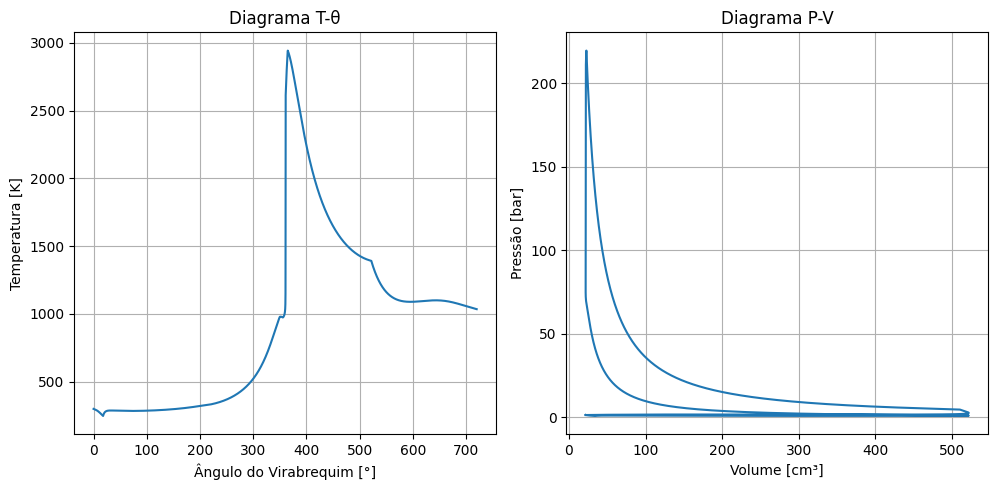

In [ ]:
############################
# RC = 24
############################

mci_d2 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=3000,
    displacement_volume=0.5e-3,
    compression_ratio=24,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_d2.setup_simulation()
mci_d2.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_d2.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xd2_data, yd2_data = mci_d2.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_d2):
    metrics = mci_d2.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_d2.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_d2.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_d2.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_d2.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_d2.states.t * 360 * mci_d2.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_d2.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_d2.states.V * 1e6, mci_d2.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_d2)

In [ ]:
df_d2 = pd.DataFrame({'Pressão': yd2_data, 'Ângulo': xd2_data})
df_d2

,Pressão,Ângulo
0,1.296925,0.100000
1,1.293883,0.200000
2,1.290873,0.300000
3,1.287895,0.400000
4,1.284948,0.500000
...,...,...
7374,1.207649,719.634375
7375,1.207090,719.734375
7376,1.206533,719.834375
7377,1.205975,719.934375


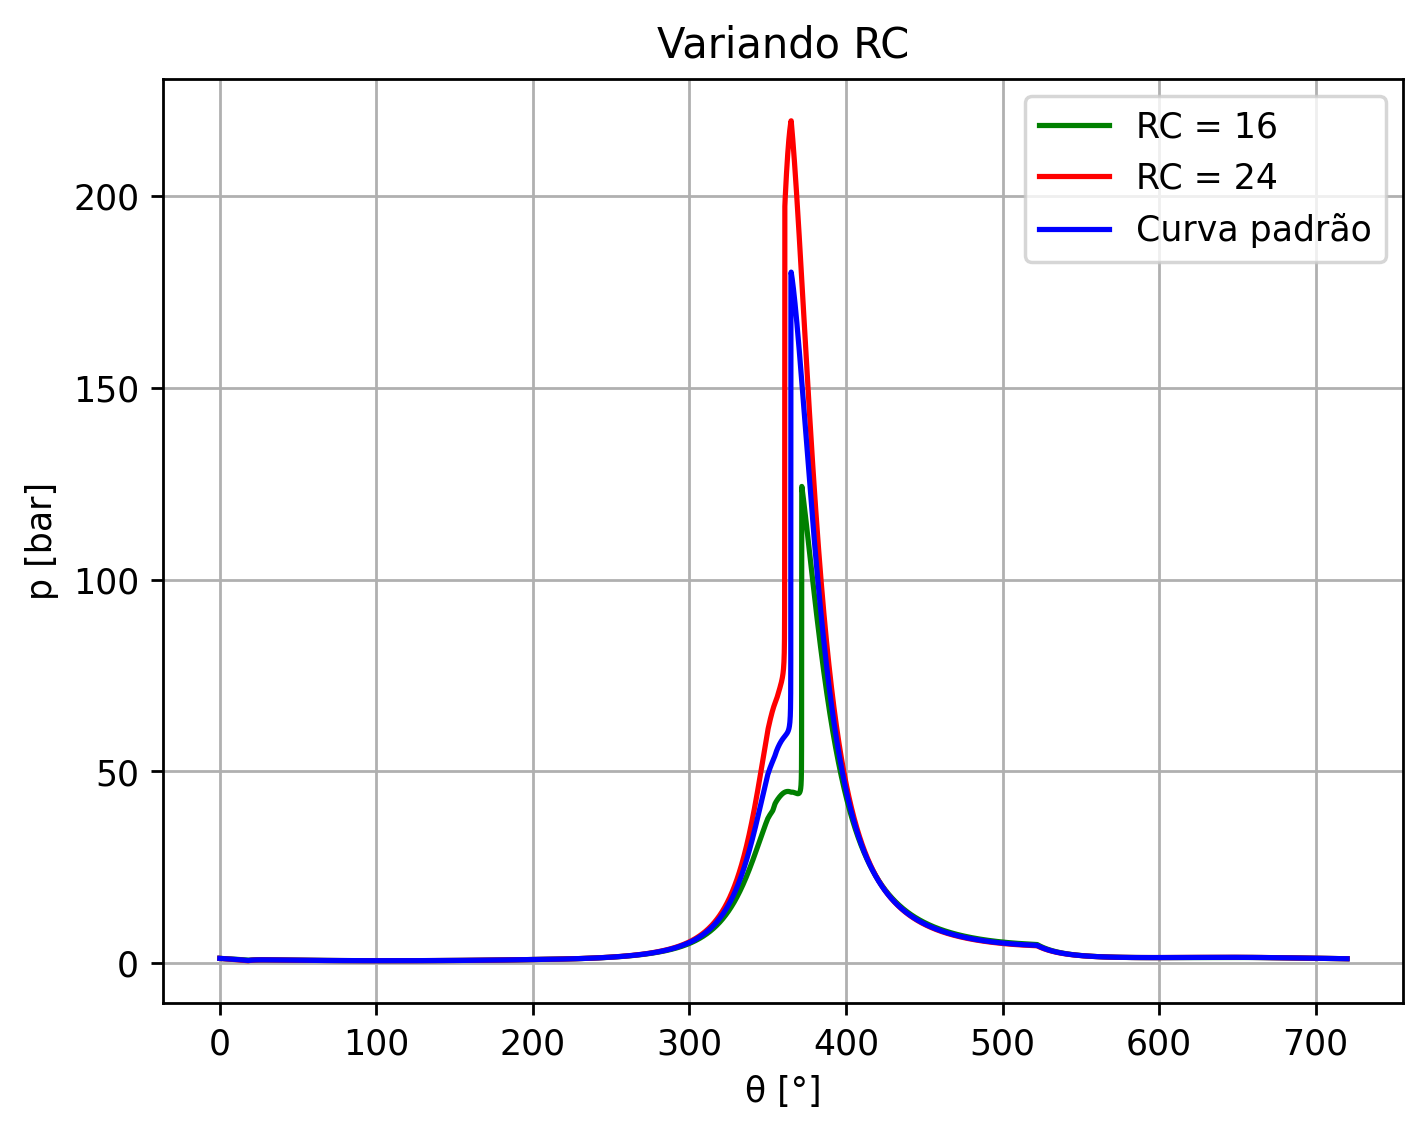

In [ ]:
plt.figure(dpi=250)
plt.title('Variando RC')
plt.plot(df_d1['Ângulo'], df_d1['Pressão'], color='green', label='RC = 16')
plt.plot(df_d2['Ângulo'], df_d2['Pressão'], color='red', label='RC = 24')
plt.plot(df_1['Ângulo'], df_1['Pressão'], color='blue', label='Curva padrão')
plt.xlabel('θ [°]')
plt.ylabel('p [bar]')
plt.legend()
plt.grid(True)
plt.savefig('RC_varia.png', dpi=300, bbox_inches='tight')
plt.show()

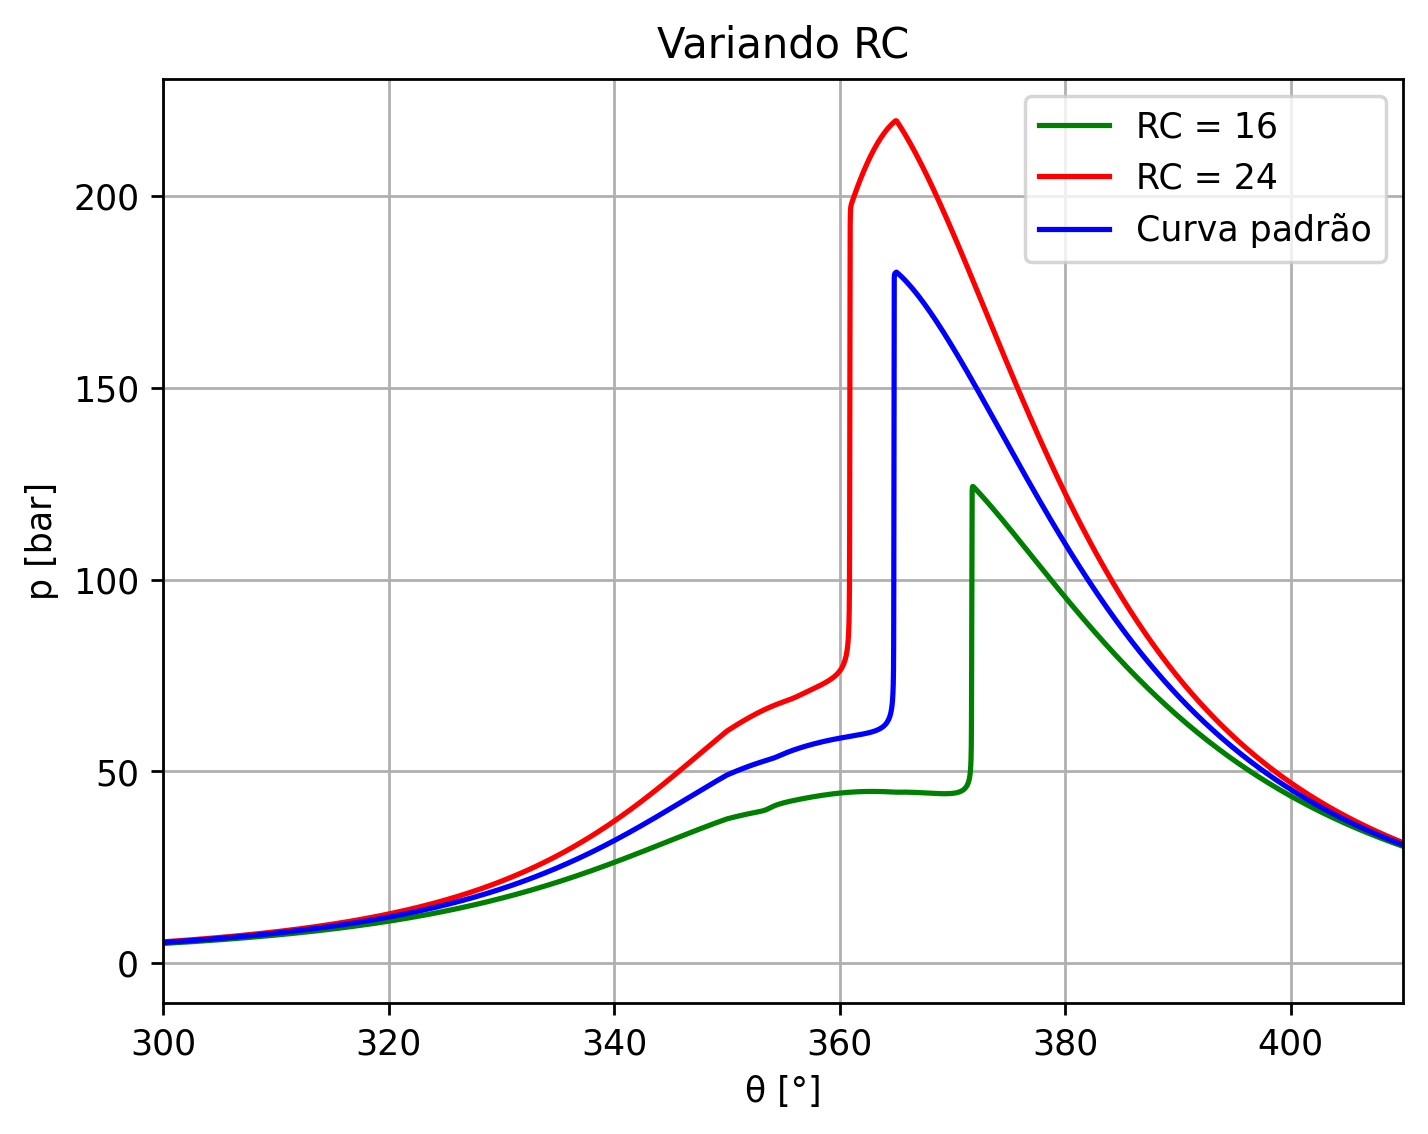

In [ ]:
plt.figure(dpi=250)
plt.title('Variando RC')
plt.plot(df_d1['Ângulo'], df_d1['Pressão'], color='green', label='RC = 16')
plt.plot(df_d2['Ângulo'], df_d2['Pressão'], color='red', label='RC = 24')
plt.plot(df_1['Ângulo'], df_1['Pressão'], color='blue', label='Curva padrão')
plt.xlabel('θ [°]')
plt.xlim(300, 410)
plt.ylabel('p [bar]')
plt.legend()
plt.grid(True)
plt.savefig('RC_varia_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

In [132]:
# Pequeno valor para evitar divisão por zero
epsilon = 1e-6  

# Criando colunas de diferença percentual para cada curva em relação a df_1
df_d1['Diferença %'] = np.abs(((df_d1['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)
df_d2['Diferença %'] = np.abs(((df_d2['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)

# Filtrando apenas os valores no intervalo de 362° a 370°
intervalo_d1 = (df_d1['Ângulo'] >= 362) & (df_d1['Ângulo'] <= 370)
intervalo_d2 = (df_d2['Ângulo'] >= 362) & (df_d2['Ângulo'] <= 370)

# Exibindo os resultados com título
print("\n===== Diferença Percentual de Pressão (Ângulos de 362° a 370°) =====\n")

print("Caso RC = 16")
print(df_d1[intervalo_d1][['Ângulo', 'Diferença %']], "\n")

print("Caso RC = 24")
print(df_d2[intervalo_d2][['Ângulo', 'Diferença %']], "\n")


===== Diferença Percentual de Pressão (Ângulos de 362° a 370°) =====

Caso RC = 16
          Ângulo  Diferença %
3621  362.000391    25.058578
3622  362.100391    25.116875
3623  362.200391    25.179203
3624  362.300391    25.245944
3625  362.400391    25.317525
...          ...          ...
3697  369.512891    49.195286
3698  369.612891    49.458520
3699  369.712891    49.727002
3700  369.812891    50.000474
3701  369.912891    50.278548

[81 rows x 2 columns] 

Caso RC = 24
          Ângulo  Diferença %
3798  362.034375    28.520919
3799  362.134375    28.678070
3800  362.234375    28.828931
3801  362.334375    28.973604
3802  362.434375    29.112184
...          ...          ...
3873  369.534375    23.941171
3874  369.634375    23.911226
3875  369.734375    23.880693
3876  369.834375    23.849576
3877  369.934375    23.817882

[80 rows x 2 columns] 



#### Letra e

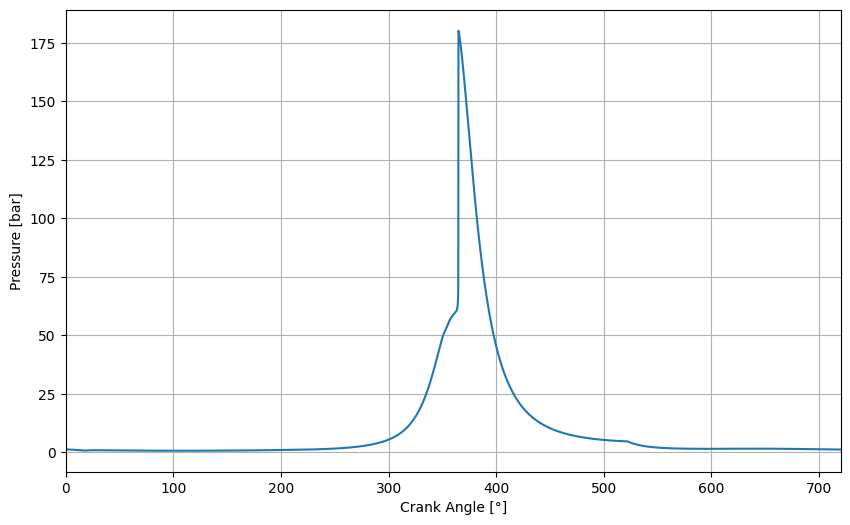

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19873878e+02
 7.19973878e+02 7.20073878e+02]
Array eixo y:
[1.29745273 1.2949193  1.29239958 ... 1.20725146 1.20670372 1.20615654]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 0.6 mm
Curso do Pistão: 2030037.5 mm

Performance:
Potência por Cilindro: 18.6 kW
Eficiência Térmica: 53.2%
Taxa de Liberação de Calor: 34.9 kW

Condições Máximas:
Pressão Máxima: 180.1 bar
Temperatura Máxima: 2881.3 K

Emissões:
CO: 3.9 ppm
CO2: 106698.0 ppm


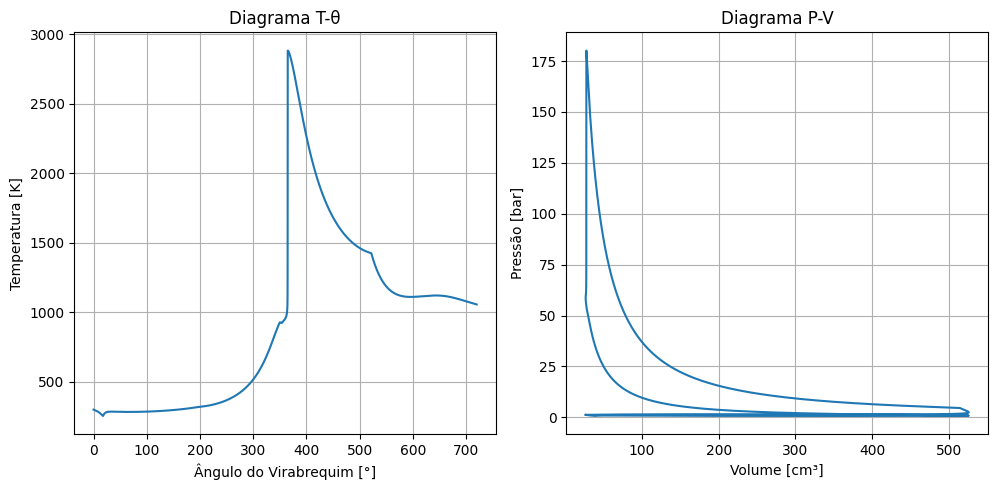

In [ ]:
##########################
# D_pistão = 0,04
##########################

mci_e1 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=3000,
    displacement_volume=0.5e-3,
    compression_ratio=20,
    piston_diameter=0.00056,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_e1.setup_simulation()
mci_e1.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_e1.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xe1_data, ye1_data = mci_1.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_e1):
    metrics = mci_e1.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_e1.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_e1.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_e1.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_e1.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_e1.states.t * 360 * mci_e1.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_e1.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_e1.states.V * 1e6, mci_e1.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_e1)

In [ ]:
df_e1 = pd.DataFrame({'Pressão': ye1_data, 'Ângulo': xe1_data})
df_e1

,Pressão,Ângulo
0,1.297453,0.100000
1,1.294919,0.200000
2,1.292400,0.300000
3,1.289893,0.400000
4,1.287401,0.500000
...,...,...
7361,1.208349,719.673878
7362,1.207800,719.773878
7363,1.207251,719.873878
7364,1.206704,719.973878


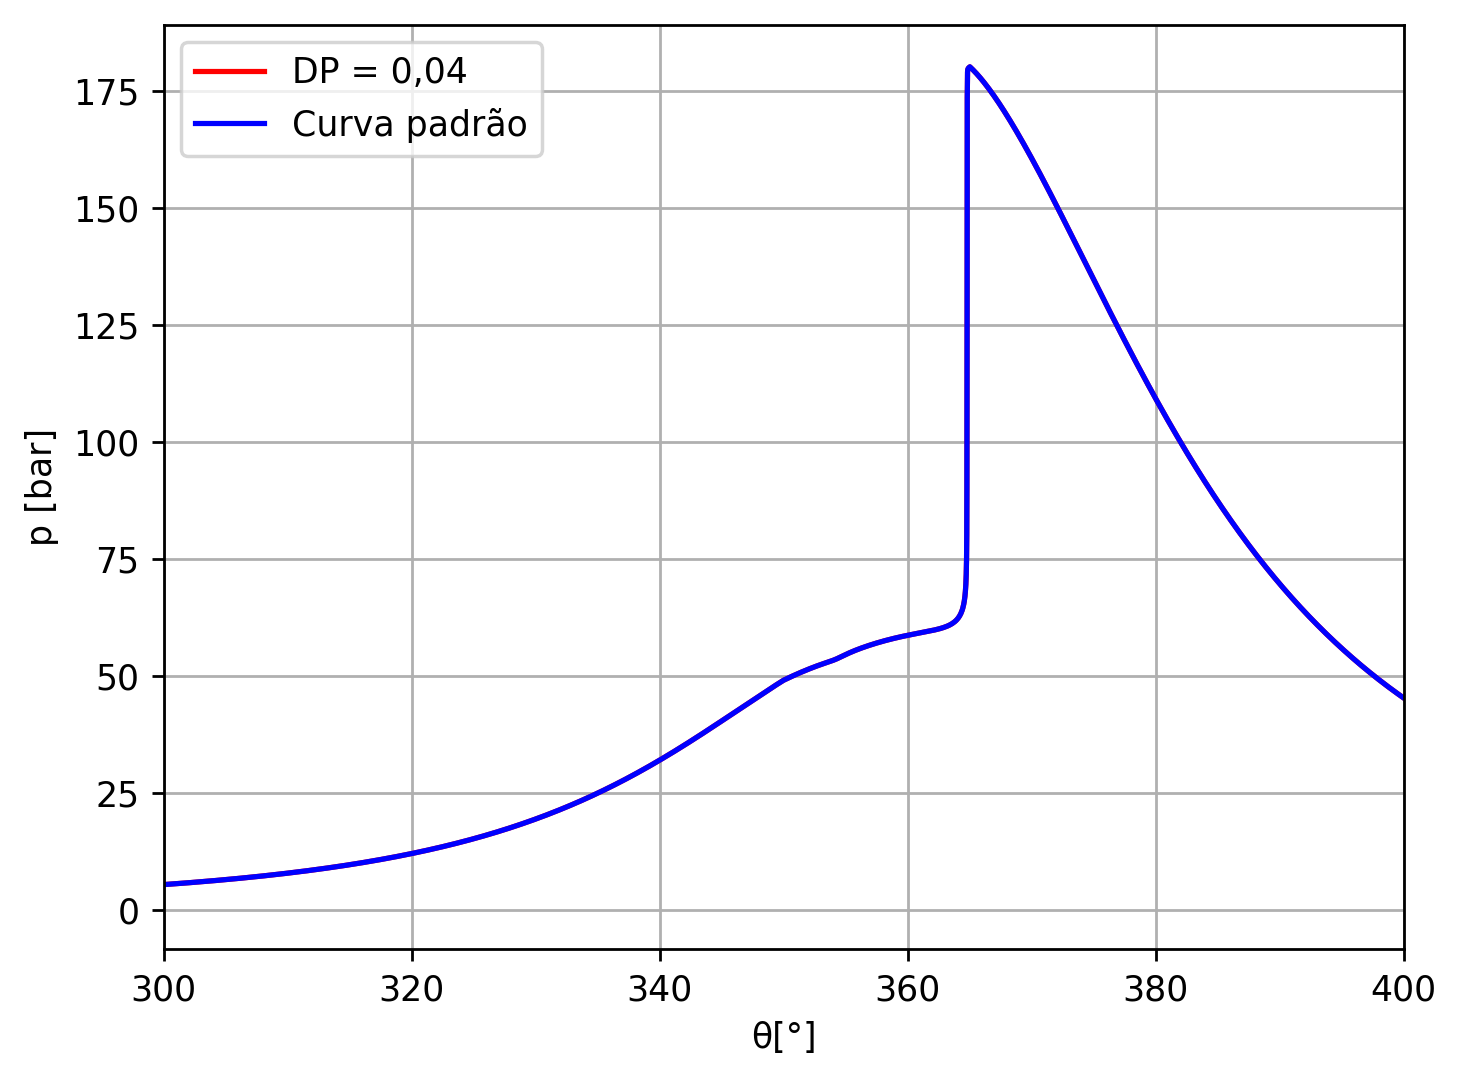

In [ ]:
plt.figure(dpi=250)
plt.plot(df_e1['Ângulo'],df_e1['Pressão'],color='red',label='DP = 0,04')
plt.plot(df_1['Ângulo'],df_1['Pressão'],color='blue',label='Curva padrão')
plt.ylabel('p [bar]')
plt.xlabel('θ[°]')
plt.xlim(300,400)
plt.legend()
plt.grid(True)

#### Letra f

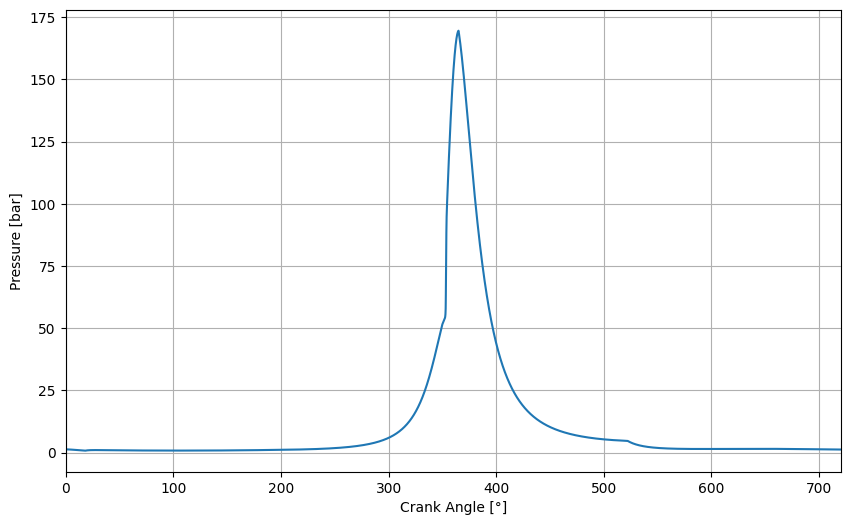

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19887696e+02
 7.19987696e+02 7.20087696e+02]
Array eixo y:
[1.29664374 1.29335035 1.29011789 ... 1.20500351 1.20455385 1.20410457]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 17.5 kW
Eficiência Térmica: 50.7%
Taxa de Liberação de Calor: 34.4 kW

Condições Máximas:
Pressão Máxima: 169.6 bar
Temperatura Máxima: 3171.8 K

Emissões:
CO: 12420.8 ppm
CO2: 118261.8 ppm


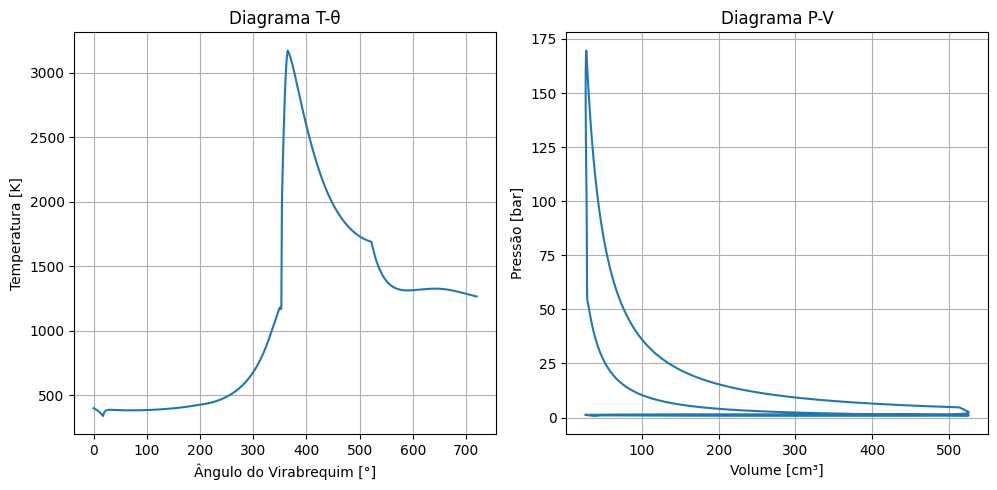

In [ ]:
#########################
# Temp. Injeção = 400 K
#########################

mci_f1 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=3000,
    displacement_volume=0.5e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=400.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_f1.setup_simulation()
mci_f1.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_f1.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xf1_data, yf1_data = mci_f1.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_f1):
    metrics = mci_f1.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_f1.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_f1.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_f1.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_f1.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_f1.states.t * 360 * mci_f1.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_f1.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_f1.states.V * 1e6, mci_f1.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_f1)

In [ ]:
df_f1 = pd.DataFrame({'Pressão': yf1_data, 'Ângulo': xf1_data})
df_f1

,Pressão,Ângulo
0,1.296644,0.100000
1,1.293350,0.200000
2,1.290118,0.300000
3,1.286944,0.400000
4,1.283828,0.500000
...,...,...
7372,1.205904,719.687696
7373,1.205454,719.787696
7374,1.205004,719.887696
7375,1.204554,719.987696


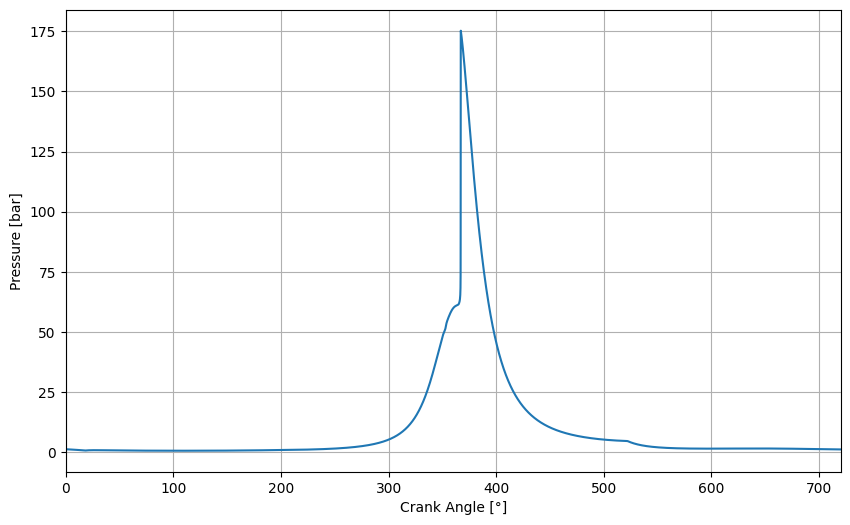

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19821393e+02
 7.19921393e+02 7.20021393e+02]
Array eixo y:
[1.29765731 1.29531818 1.29298273 ... 1.2083585  1.20777774 1.2071976 ]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 18.6 kW
Eficiência Térmica: 51.6%
Taxa de Liberação de Calor: 36.1 kW

Condições Máximas:
Pressão Máxima: 175.2 bar
Temperatura Máxima: 2766.6 K

Emissões:
CO: 1.9 ppm
CO2: 101210.0 ppm


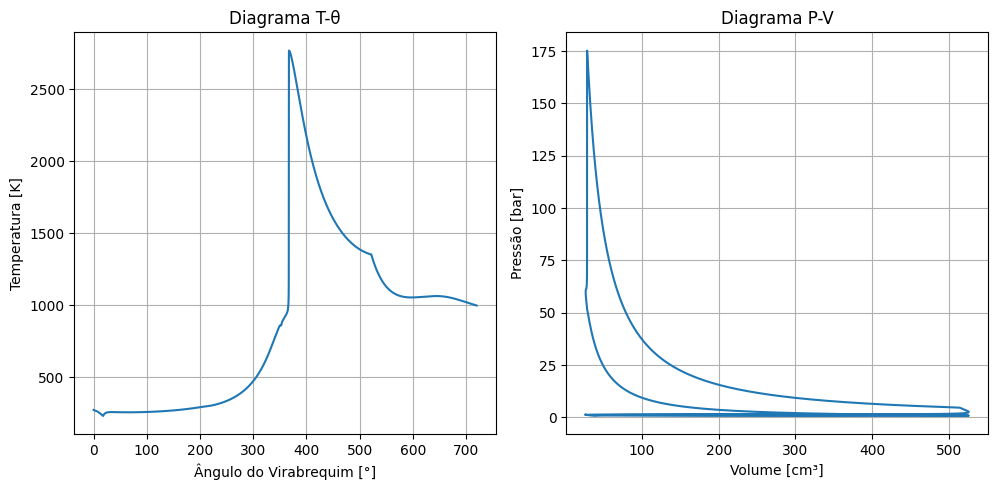

In [ ]:
#########################
# Temp. Injeção = 275 K
#########################

mci_f2 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=3000,
    displacement_volume=0.5e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=275.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_f2.setup_simulation()
mci_f2.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_f2.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xf2_data, yf2_data = mci_f2.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_f1):
    metrics = mci_f2.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_f2.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_f2.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_f2.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_f2.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_f2.states.t * 360 * mci_f2.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_f2.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_f2.states.V * 1e6, mci_f2.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_f2)

In [ ]:
df_f2 = pd.DataFrame({'Pressão': yf2_data, 'Ângulo': xf2_data})
df_f2

,Pressão,Ângulo
0,1.298276,0.10000
1,1.296530,0.20000
2,1.294762,0.30000
3,1.292972,0.40000
4,1.291162,0.50000
...,...,...
7197,1.382241,719.60005
7198,1.378769,719.70005
7199,1.375315,719.80005
7200,1.371878,719.90005


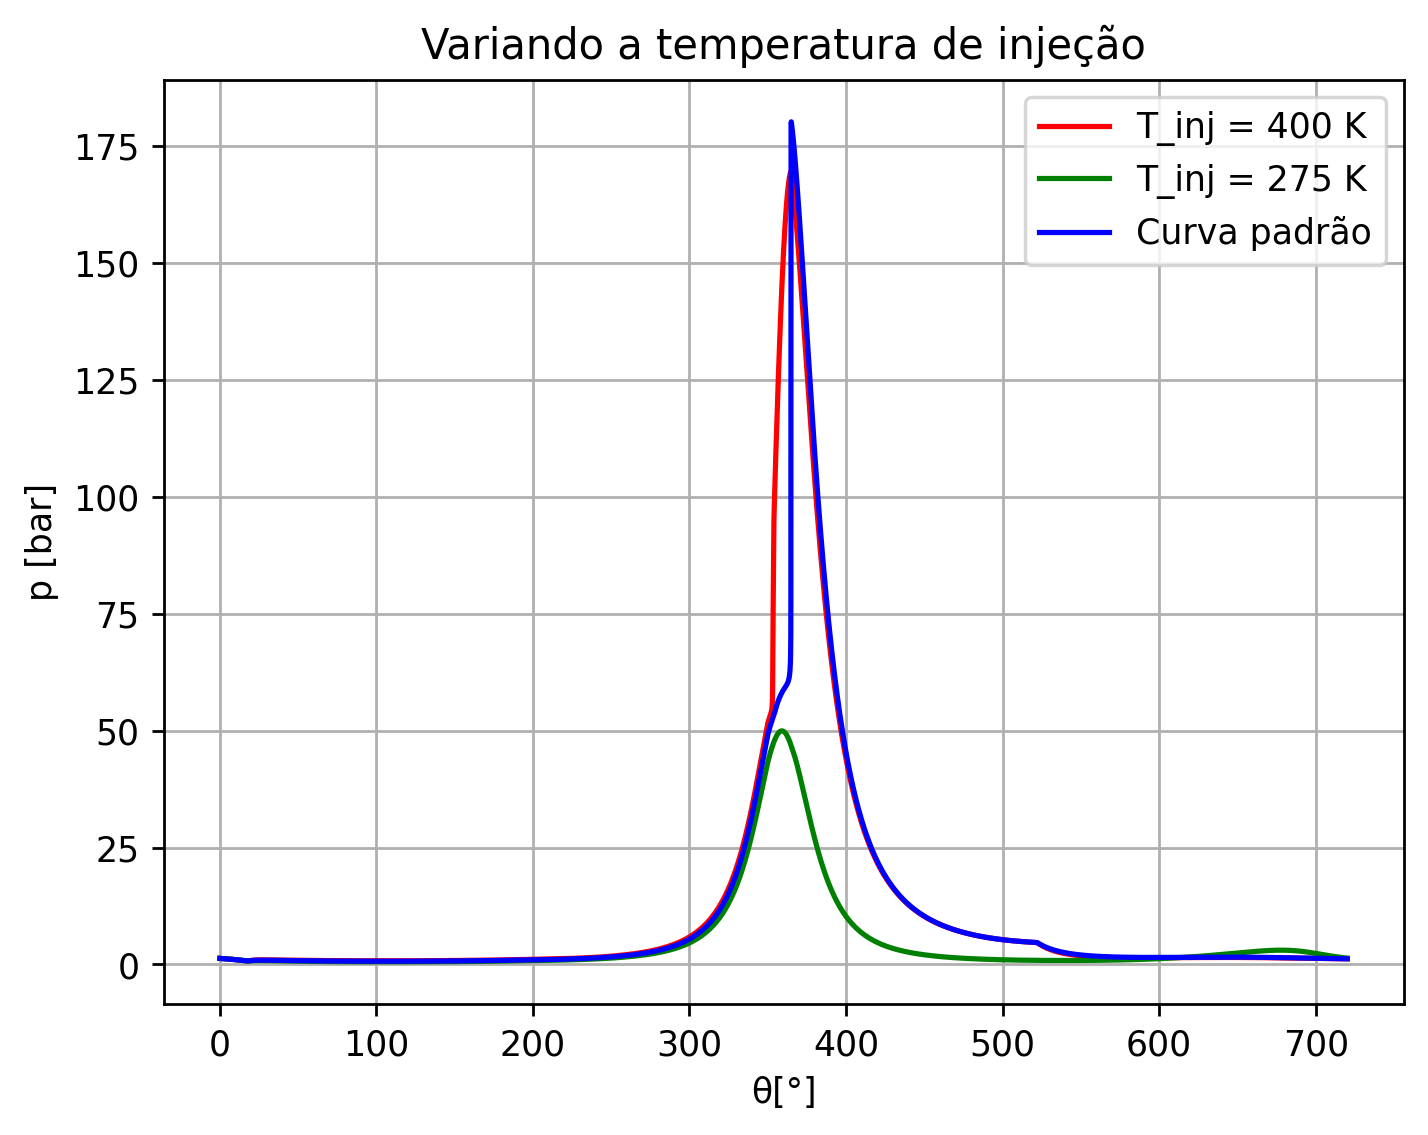

In [ ]:
plt.figure(dpi=250)
plt.plot(df_f1['Ângulo'],df_f1['Pressão'],color='red',label='T_inj = 400 K')
plt.plot(df_f2['Ângulo'],df_f2['Pressão'],color='green',label='T_inj = 275 K')
plt.plot(df_1['Ângulo'],df_1['Pressão'],color='blue',label='Curva padrão')
plt.ylabel('p [bar]')
plt.xlabel('θ[°]')
plt.title('Variando a temperatura de injeção')
plt.legend()
plt.grid(True)
plt.savefig('T_ing_varia.png', dpi=300, bbox_inches='tight')
plt.show()

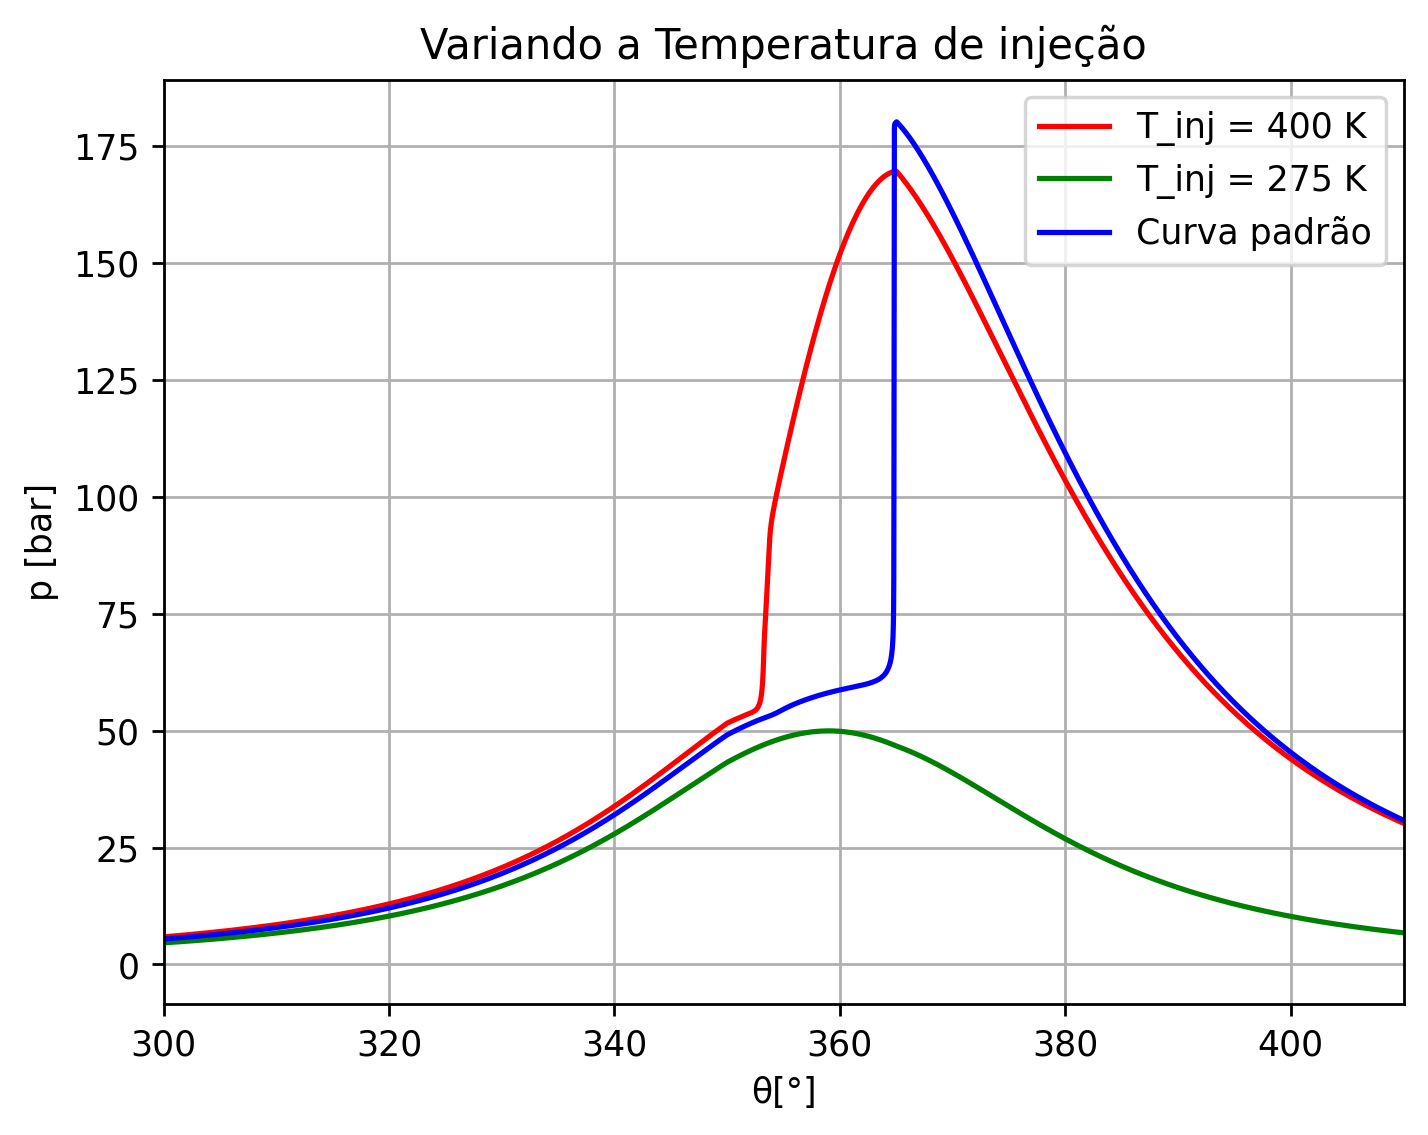

In [ ]:
plt.figure(dpi=250)
plt.plot(df_f1['Ângulo'],df_f1['Pressão'],color='red',label='T_inj = 400 K')
plt.plot(df_f2['Ângulo'],df_f2['Pressão'],color='green',label='T_inj = 275 K')
plt.plot(df_1['Ângulo'],df_1['Pressão'],color='blue',label='Curva padrão')
plt.ylabel('p [bar]')
plt.xlabel('θ[°]')
plt.title('Variando a Temperatura de injeção')
plt.legend()
plt.xlim(300,410)
plt.grid(True)
plt.savefig('T_ing_varia_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

In [135]:
# Pequeno valor para evitar divisão por zero
epsilon = 1e-6  

# Criando colunas de diferença percentual para cada curva em relação a df_1
df_f1['Diferença %'] = np.abs(((df_f1['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)
df_f2['Diferença %'] = np.abs(((df_f2['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)

# Filtrando apenas os valores no intervalo de 362° a 370°
intervalo_f1 = (df_f1['Ângulo'] >= 342) & (df_f1['Ângulo'] <= 370)
intervalo_f2 = (df_f2['Ângulo'] >= 362) & (df_f2['Ângulo'] <= 370)

# Exibindo os resultados com título
print("\n===== Diferença Percentual de Pressão (Ângulos de 362° a 370°) =====\n")

print("Caso T_inj = 400 K")
print(df_f1[intervalo_f1][['Ângulo', 'Diferença %']], "\n")

print("Caso T_inj = 275 K")
print(df_f2[intervalo_f2][['Ângulo', 'Diferença %']], "\n")


===== Diferença Percentual de Pressão (Ângulos de 362° a 370°) =====

Caso T_inj = 400 K
          Ângulo  Diferença %
3421  342.000196     5.523889
3422  342.100196     5.517050
3423  342.200196     5.510239
3424  342.300196     5.503455
3425  342.400196     5.496698
...          ...          ...
3871  369.587696     2.970682
3872  369.687696     2.942947
3873  369.787696     2.915307
3874  369.887696     2.887766
3875  369.987696     2.860327

[455 rows x 2 columns] 

Caso T_inj = 275 K
         Ângulo  Diferença %
3621  362.00005    17.809001
3622  362.10005    17.982782
3623  362.20005    18.161776
3624  362.30005    18.346371
3625  362.40005    18.537007
...         ...          ...
3696  369.50005    51.917308
3697  369.60005    52.319139
3698  369.70005    52.728963
3699  369.80005    53.146984
3700  369.90005    53.573379

[80 rows x 2 columns] 



#### Letra g

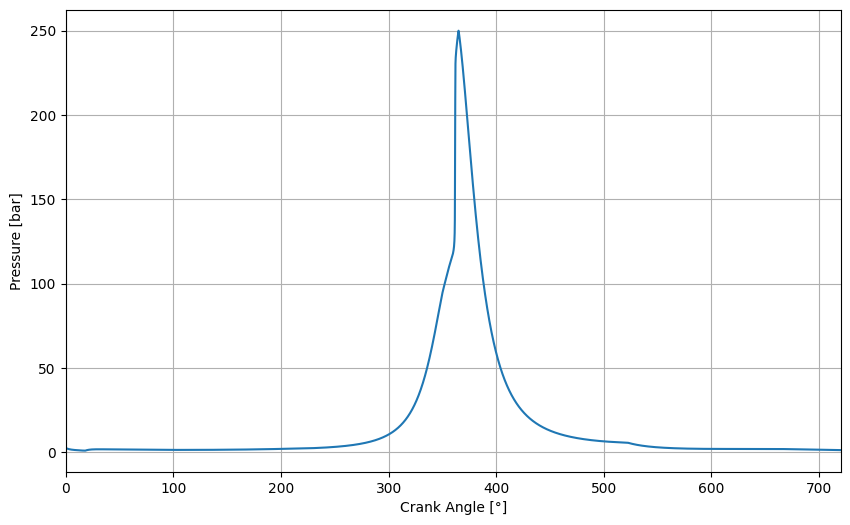

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19881262e+02
 7.19981262e+02 7.20081262e+02]
Array eixo y:
[2.46722572 2.43529585 2.40418481 ... 1.21947949 1.21852923 1.21758059]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 20.6 kW
Eficiência Térmica: 59.0%
Taxa de Liberação de Calor: 34.9 kW

Condições Máximas:
Pressão Máxima: 249.9 bar
Temperatura Máxima: 2166.0 K

Emissões:
CO: 0.1 ppm
CO2: 56442.5 ppm


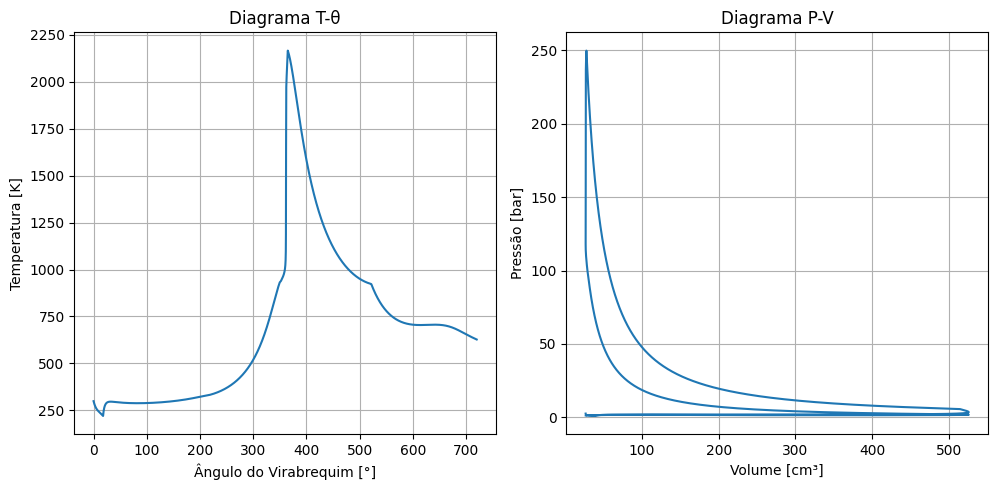

In [ ]:
mci_g1 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=3000,
    displacement_volume=0.5e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=2.5e5 
)

# Configurar e executar a simulação
mci_g1.setup_simulation()
mci_g1.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_g1.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xg1_data, yg1_data = mci_g1.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_g1):
    metrics = mci_g1.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_g1.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_g1.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_g1.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_g1.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_g1.states.t * 360 * mci_g1.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_g1.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_g1.states.V * 1e6, mci_g1.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_g1)

In [ ]:
df_g1 = pd.DataFrame({'Pressão': yg1_data, 'Ângulo': xg1_data})
df_g1

,Pressão,Ângulo
0,2.467226,0.100000
1,2.435296,0.200000
2,2.404185,0.300000
3,2.373868,0.400000
4,2.344321,0.500000
...,...,...
7301,1.221385,719.681262
7302,1.220431,719.781262
7303,1.219479,719.881262
7304,1.218529,719.981262


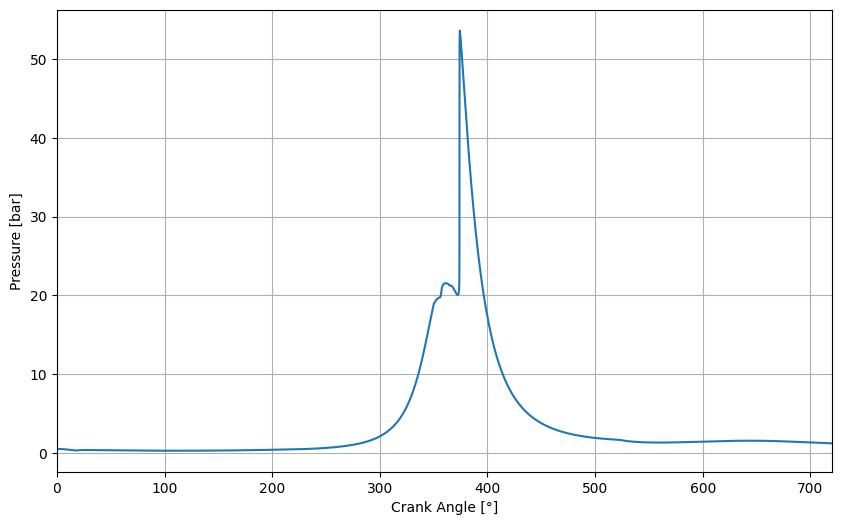

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19891029e+02
 7.19991029e+02 7.20091029e+02]
Array eixo y:
[0.49998988 0.4999595  0.49990889 ... 1.20625436 1.20573919 1.20522451]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 5.2 kW
Eficiência Térmica: 45.5%
Taxa de Liberação de Calor: 11.5 kW

Condições Máximas:
Pressão Máxima: 53.6 bar
Temperatura Máxima: 2269.4 K

Emissões:
CO: 173297.3 ppm
CO2: 24426.9 ppm


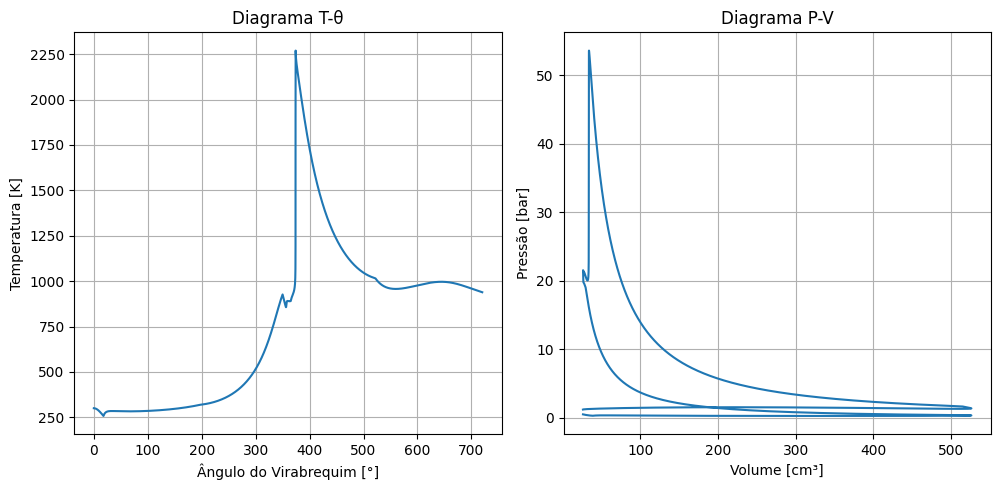

In [ ]:
mci_g2 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=3000,
    displacement_volume=0.5e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=198.0,
    intake_pressure=0.5e5 
)

# Configurar e executar a simulação
mci_g2.setup_simulation()
mci_g2.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_g2.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xg2_data, yg2_data = mci_g2.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_g2):
    metrics = mci_g2.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_g2.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_g2.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_g2.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_g2.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_g2.states.t * 360 * mci_g2.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_g2.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_g2.states.V * 1e6, mci_g2.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_g2)

In [ ]:
df_g2 = pd.DataFrame({'Pressão': yg2_data, 'Ângulo': xg2_data})
df_g2

,Pressão,Ângulo
0,0.499990,0.100000
1,0.499960,0.200000
2,0.499909,0.300000
3,0.499838,0.400000
4,0.499747,0.500000
...,...,...
7351,1.207286,719.691029
7352,1.206770,719.791029
7353,1.206254,719.891029
7354,1.205739,719.991029


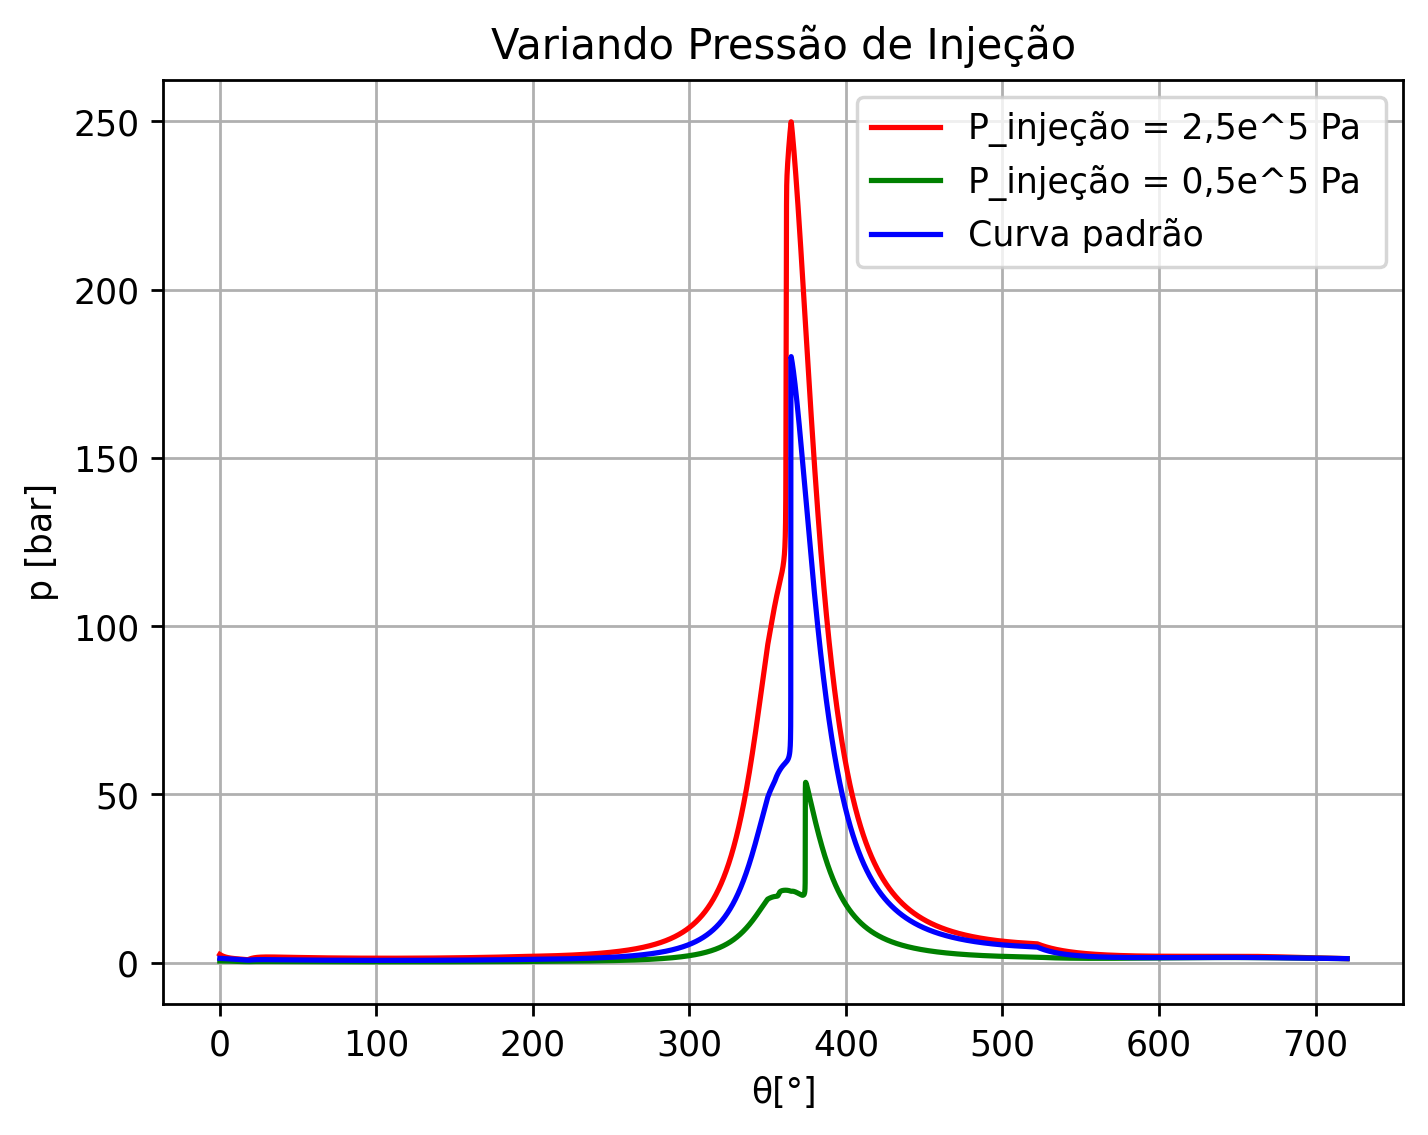

In [ ]:
plt.figure(dpi=250)
plt.plot(df_g1['Ângulo'],df_g1['Pressão'],color='red',label='P_injeção = 2,5e^5 Pa ')
plt.plot(df_g2['Ângulo'],df_g2['Pressão'],color='green',label='P_injeção = 0,5e^5 Pa ')
plt.plot(df_1['Ângulo'],df_1['Pressão'],color='blue',label='Curva padrão')
plt.ylabel('p [bar]')
plt.xlabel('θ[°]')
plt.title('Variando Pressão de Injeção')
plt.legend()
plt.grid(True)
plt.savefig('P_inj_varia.png', dpi=300, bbox_inches='tight')
plt.show()

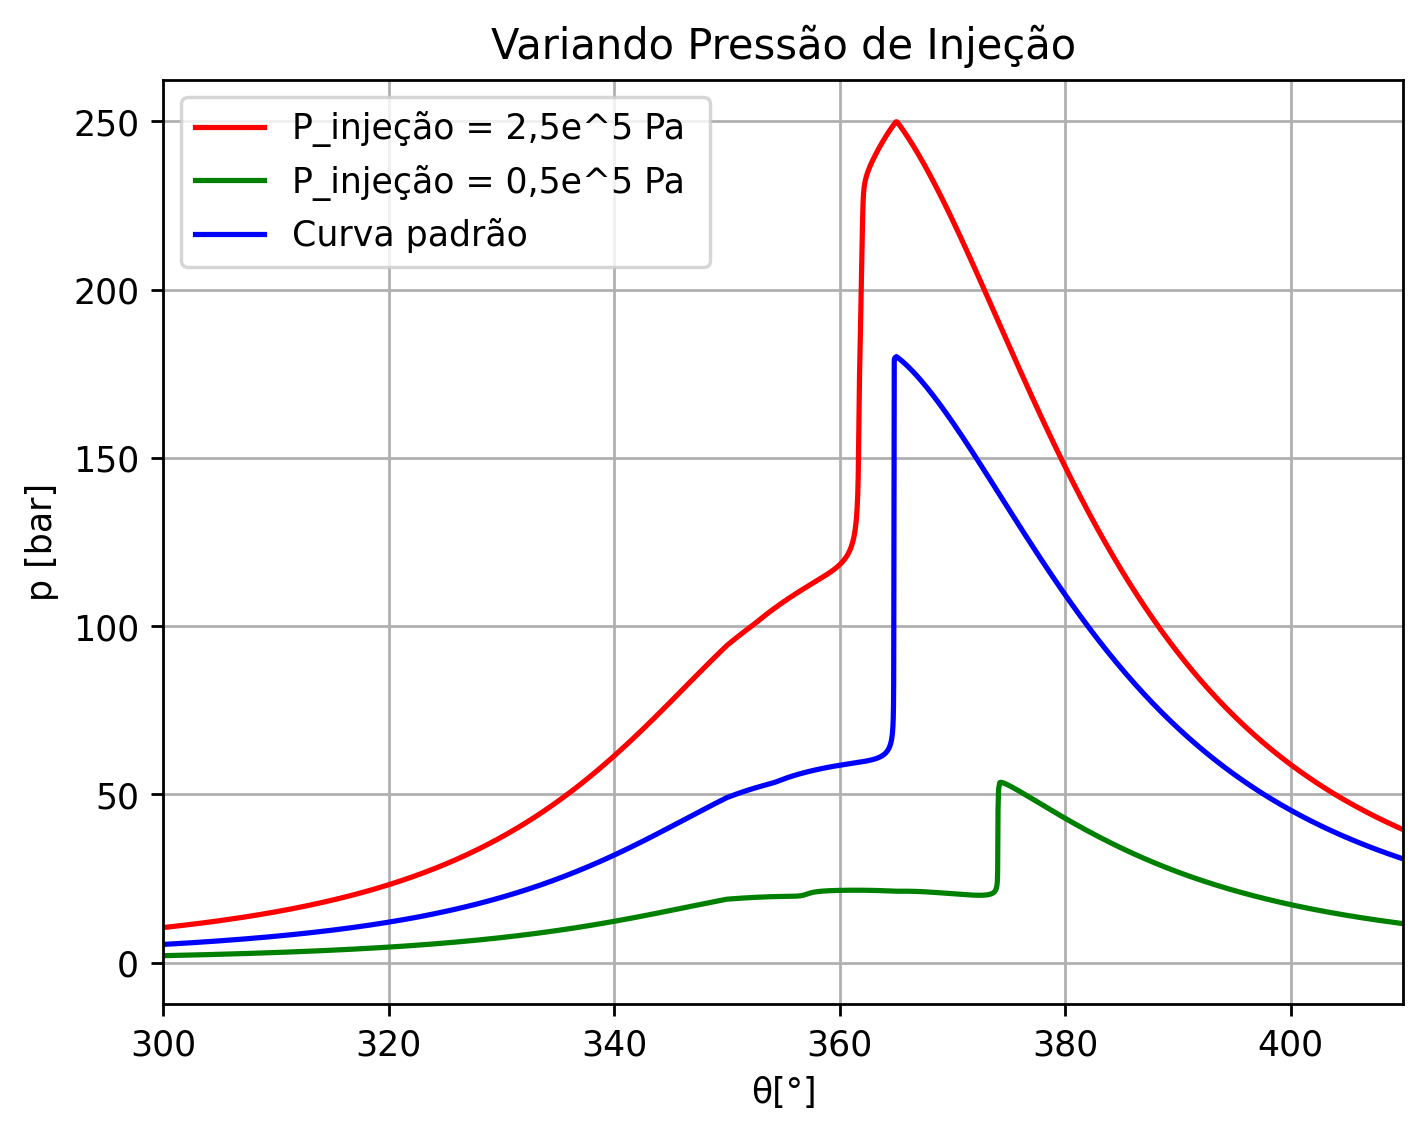

In [109]:
plt.figure(dpi=250)
plt.plot(df_g1['Ângulo'],df_g1['Pressão'],color='red',label='P_injeção = 2,5e^5 Pa ')
plt.plot(df_g2['Ângulo'],df_g2['Pressão'],color='green',label='P_injeção = 0,5e^5 Pa ')
plt.plot(df_1['Ângulo'],df_1['Pressão'],color='blue',label='Curva padrão')
plt.ylabel('p [bar]')
plt.xlabel('θ[°]')
plt.title('Variando Pressão de Injeção')
plt.legend()
plt.grid(True)
plt.xlim(300,410)
plt.savefig('P_inj_varia_zoom22.png', dpi=300, bbox_inches='tight')
plt.show()

In [139]:
# Pequeno valor para evitar divisão por zero
epsilon = 1e-6  

# Criando colunas de diferença percentual para cada curva em relação a df_1
df_g1['Diferença %'] = np.abs(((df_g1['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)
df_g2['Diferença %'] = np.abs(((df_g2['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)

# Filtrando apenas os valores no intervalo de 362° a 370°
intervalo_g1 = (df_g1['Ângulo'] >= 362) & (df_g1['Ângulo'] <= 370)
intervalo_g2 = (df_g2['Ângulo'] >= 362) & (df_g2['Ângulo'] <= 370)

# Exibindo os resultados com título
print("\n===== Diferença Percentual de Pressão (Ângulos de 362° a 370°) =====\n")

print("Caso P_injeção = 2.5 × 10⁵ Pa")
print(df_g1[intervalo_g1][['Ângulo', 'Diferença %']], "\n")

print("Caso P_injeção = 0.5 × 10⁵ Pa")
print(df_g2[intervalo_g2][['Ângulo', 'Diferença %']], "\n")



===== Diferença Percentual de Pressão (Ângulos de 362° a 370°) =====

Caso P_injeção = 2.5 × 10⁵ Pa
          Ângulo  Diferença %
3708  362.000012   134.230068
3709  362.006262   134.445141
3710  362.012512   134.592766
3711  362.018762   134.667371
3712  362.025012   134.665209
...          ...          ...
3800  369.581262    39.036070
3801  369.681262    38.315642
3802  369.781262    37.601141
3803  369.881262    36.892533
3804  369.981262    36.189776

[97 rows x 2 columns] 

Caso P_injeção = 0.5 × 10⁵ Pa
          Ângulo  Diferença %
3622  362.000794    63.976578
3623  362.100794    64.017594
3624  362.200794    64.060677
3625  362.300794    64.106042
3626  362.400794    64.153931
...          ...          ...
3698  369.525794    76.439734
3699  369.625794    76.601332
3700  369.725794    76.767387
3701  369.825794    76.937971
3702  369.925794    77.113130

[81 rows x 2 columns] 



##### Letra h

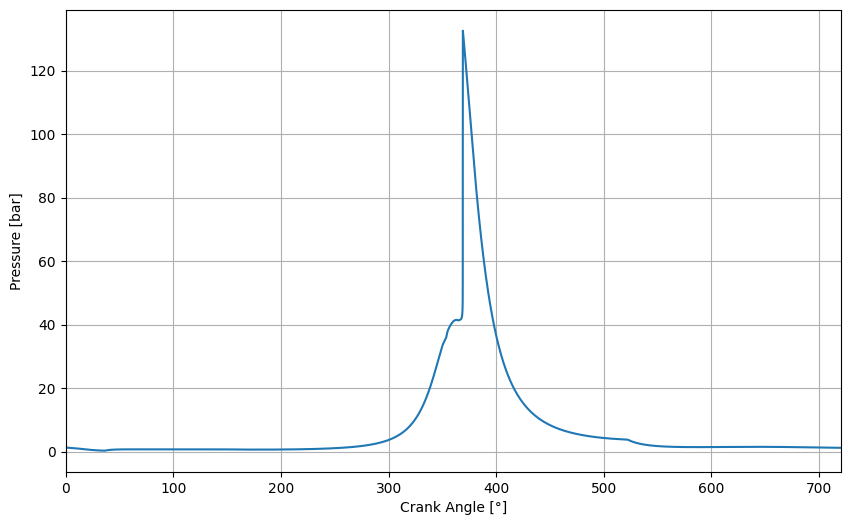

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19871936e+02
 7.19971936e+02 7.20071936e+02]
Array eixo y:
[1.29745273 1.2949193  1.29239958 ... 1.20563165 1.20515517 1.20467912]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 15.2 kW
Eficiência Térmica: 51.1%
Taxa de Liberação de Calor: 29.7 kW

Condições Máximas:
Pressão Máxima: 132.5 bar
Temperatura Máxima: 2993.9 K

Emissões:
CO: 35524.9 ppm
CO2: 102187.5 ppm


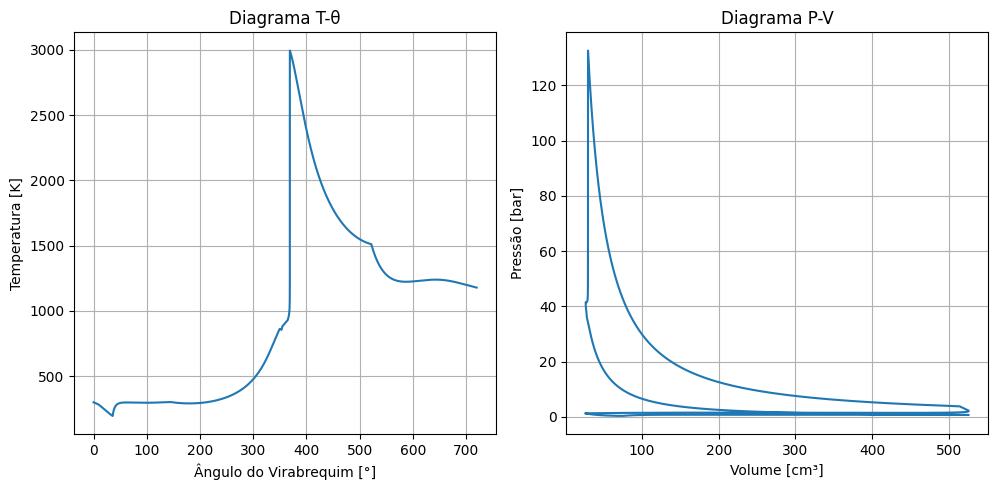

In [ ]:
mci_h1 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=3000,
    displacement_volume=0.5e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-36.0,
    intake_valve_close=144.0,
    intake_pressure=1.3e5 
)

# Configurar e executar a simulação
mci_h1.setup_simulation()
mci_h1.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_h1.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xh1_data, yh1_data = mci_h1.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_h1):
    metrics = mci_h1.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_h1.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_h1.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_h1.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_h1.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_h1.states.t * 360 * mci_h1.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_h1.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_h1.states.V * 1e6, mci_h1.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_h1)

In [ ]:
df_h1 = pd.DataFrame({'Pressão': yh1_data, 'Ângulo': xh1_data})
df_h1

,Pressão,Ângulo
0,1.297453,0.100000
1,1.294919,0.200000
2,1.292400,0.300000
3,1.289893,0.400000
4,1.287401,0.500000
...,...,...
7457,1.206586,719.671936
7458,1.206109,719.771936
7459,1.205632,719.871936
7460,1.205155,719.971936


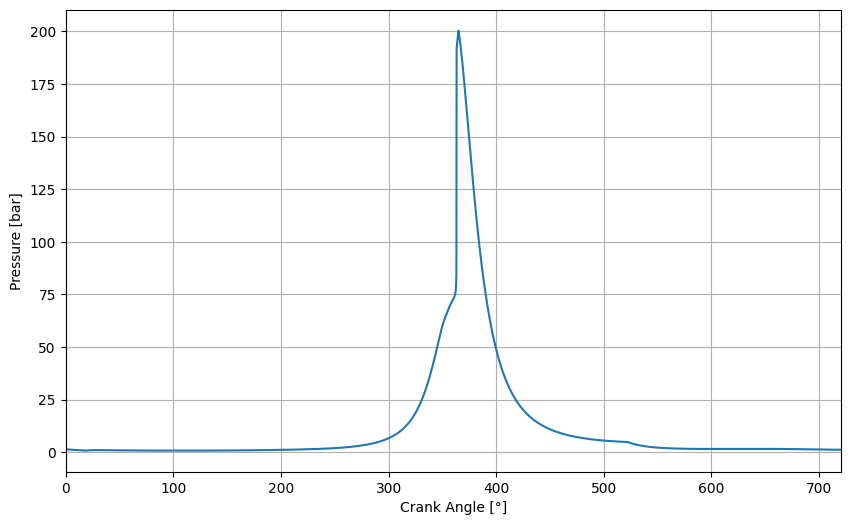

Array eixo x:
[1.00000000e-01 2.00000000e-01 3.00000000e-01 ... 7.19868176e+02
 7.19968176e+02 7.20068176e+02]
Array eixo y:
[1.49240964 1.4849617  1.47765269 ... 1.20974104 1.20909708 1.20845388]
RESULTADOS DA SIMULAÇÃO DO MOTOR

Parâmetros do Motor:
Cilindrada: 500.0 cm³
Razão de Compressão: 20.0
Diâmetro do Pistão: 73.0 mm
Curso do Pistão: 119.5 mm

Performance:
Potência por Cilindro: 19.3 kW
Eficiência Térmica: 55.1%
Taxa de Liberação de Calor: 35.0 kW

Condições Máximas:
Pressão Máxima: 200.3 bar
Temperatura Máxima: 2682.3 K

Emissões:
CO: 0.7 ppm
CO2: 88894.4 ppm


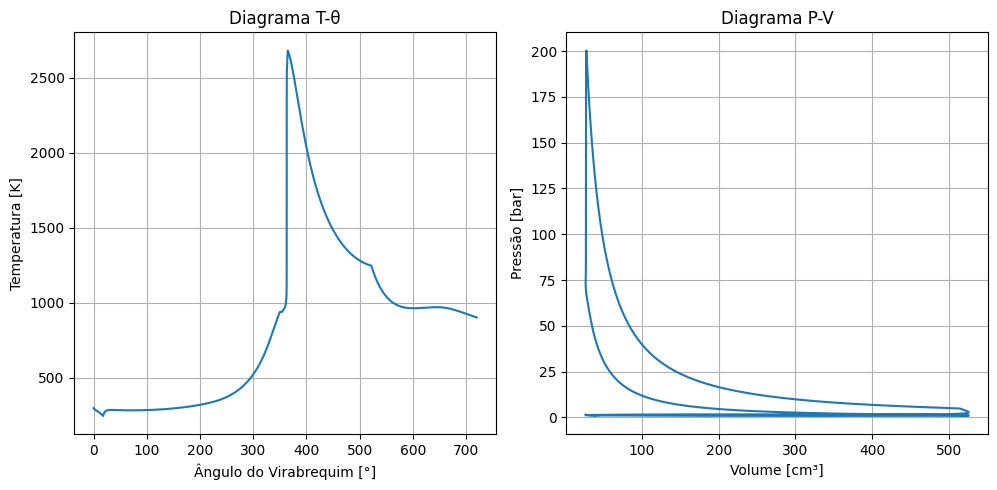

In [ ]:
mci_h2 = InternalCombustionEngineSimulator(
    air_composition='o2:1, n2:3.76',
    rpm=3000,
    displacement_volume=0.5e-3,
    compression_ratio=20,
    piston_diameter=0.073,
    intake_temperature=300.0,  # Temperatura de admissão em K
    intake_valve_open=-18.0,
    intake_valve_close=252.0,
    intake_pressure=1.5e5 
)

# Configurar e executar a simulação
mci_h2.setup_simulation()
mci_h2.run_simulation()

# Primeiro, gerar o gráfico pressão-ângulo para criar os dados necessários
mci_h2.plot_pressure_angle()

# Agora você pode obter os dados dos eixos com segurança
xh2_data, yh2_data = mci_h2.save_eixos()

# Função para exibir resultados completos
def display_full_results(mci_h2):
    metrics = mci_h2.calculate_performance()
    
    print("=" * 50)
    print("RESULTADOS DA SIMULAÇÃO DO MOTOR")
    print("=" * 50)
    
    print("\nParâmetros do Motor:")
    print(f"Cilindrada: {mci_h2.displacement_volume*1e6:.1f} cm³")
    print(f"Razão de Compressão: {mci_h2.compression_ratio:.1f}")
    print(f"Diâmetro do Pistão: {mci_h2.piston_diameter*1000:.1f} mm")
    print(f"Curso do Pistão: {mci_h2.stroke*1000:.1f} mm")
    
    print("\nPerformance:")
    print(f"Potência por Cilindro: {metrics['power']:.1f} kW")
    print(f"Eficiência Térmica: {metrics['efficiency']:.1f}%")
    print(f"Taxa de Liberação de Calor: {metrics['heat_release_rate']:.1f} kW")
    
    print("\nCondições Máximas:")
    print(f"Pressão Máxima: {metrics['max_pressure']:.1f} bar")
    print(f"Temperatura Máxima: {metrics['max_temperature']:.1f} K")
    
    print("\nEmissões:")
    print(f"CO: {metrics['co_emissions']:.1f} ppm")
    print(f"CO2: {metrics['co2_emissions']:.1f} ppm")
    
    # Gerar todos os gráficos
    plt.figure(figsize=(15, 5))
    
    # Diagrama P-θ
    angles = mci_h2.states.t * 360 * mci_h2.frequency
    
    # Diagrama T-θ
    plt.subplot(131)
    plt.plot(angles, mci_h2.states.T)
    plt.xlabel('Ângulo do Virabrequim [°]')
    plt.ylabel('Temperatura [K]')
    plt.title('Diagrama T-θ')
    plt.grid(True)
    
    # Diagrama P-V
    plt.subplot(132)
    plt.plot(mci_h2.states.V * 1e6, mci_h2.states.P/1e5)
    plt.xlabel('Volume [cm³]')
    plt.ylabel('Pressão [bar]')
    plt.title('Diagrama P-V')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exibir todos os resultados
display_full_results(mci_h2)

In [ ]:
df_h2 = pd.DataFrame({'Pressão': yh2_data, 'Ângulo': xh2_data})
df_h2

,Pressão,Ângulo
0,1.492410,0.100000
1,1.484962,0.200000
2,1.477653,0.300000
3,1.470479,0.400000
4,1.463438,0.500000
...,...,...
7406,1.211031,719.668176
7407,1.210386,719.768176
7408,1.209741,719.868176
7409,1.209097,719.968176


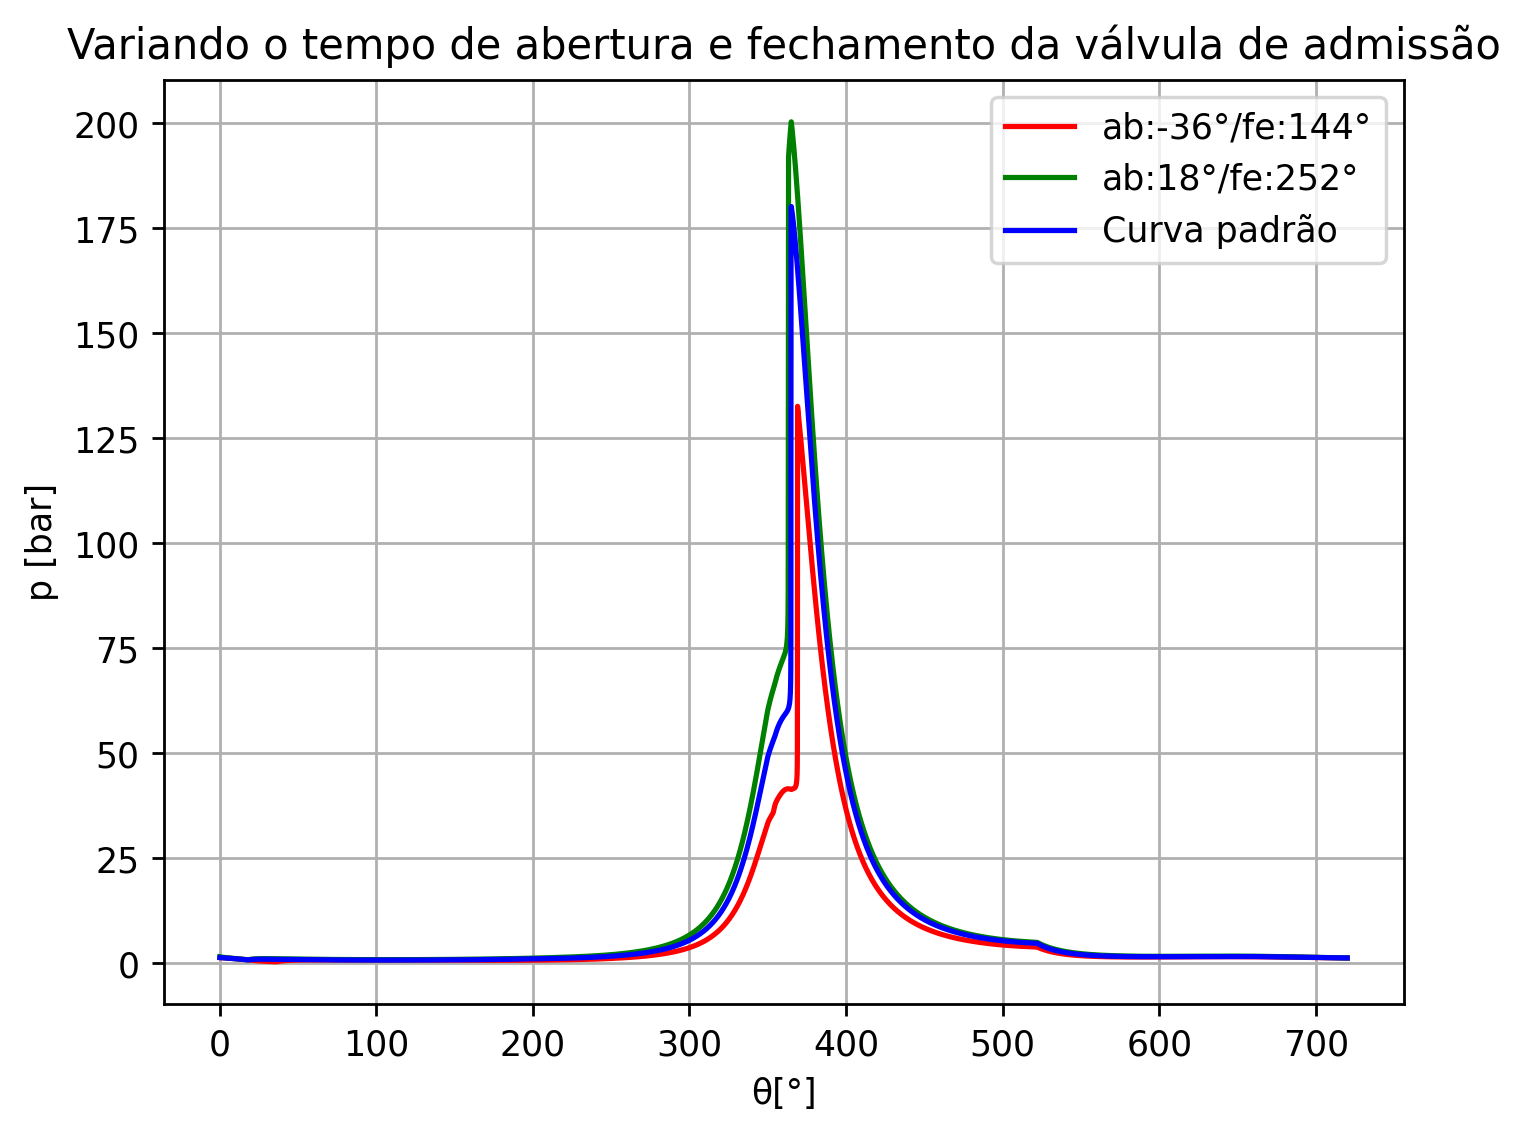

In [110]:
plt.figure(dpi=250)
plt.title('Variando o tempo de abertura e fechamento da válvula de admissão')
plt.plot(df_h1['Ângulo'],df_h1['Pressão'],color='red',label='ab:-36°/fe:144°')
plt.plot(df_h2['Ângulo'],df_h2['Pressão'],color='green',label='ab:18°/fe:252°')
plt.plot(df_1['Ângulo'],df_1['Pressão'],color='blue',label='Curva padrão')
plt.ylabel('p [bar]')
plt.xlabel('θ[°]')
plt.legend()
plt.grid(True)
plt.savefig('evo_varia.png', dpi=300, bbox_inches='tight')
plt.show()

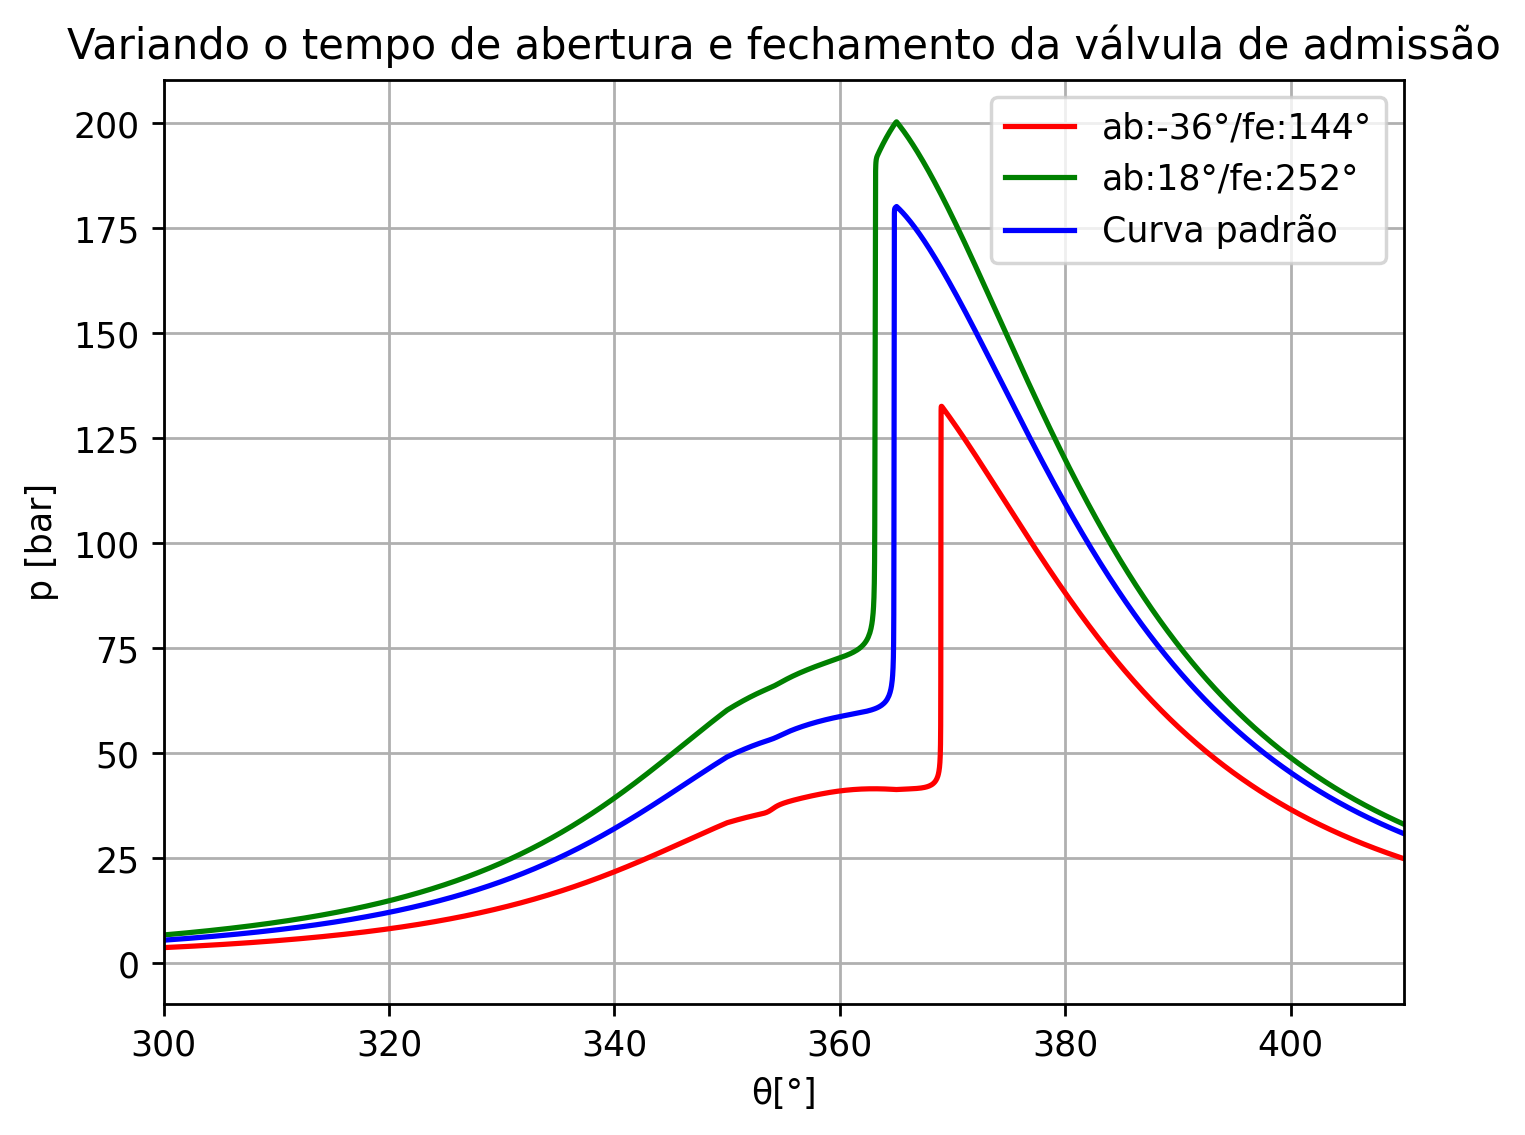

In [111]:
plt.figure(dpi=250)
plt.title('Variando o tempo de abertura e fechamento da válvula de admissão')
plt.plot(df_h1['Ângulo'],df_h1['Pressão'],color='red',label='ab:-36°/fe:144°')
plt.plot(df_h2['Ângulo'],df_h2['Pressão'],color='green',label='ab:18°/fe:252°')
plt.plot(df_1['Ângulo'],df_1['Pressão'],color='blue',label='Curva padrão')
plt.ylabel('p [bar]')
plt.xlabel('θ[°]')
plt.xlim(300,410)
plt.legend()
plt.grid(True)
plt.savefig('evo_varia_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

In [140]:
# Pequeno valor para evitar divisão por zero
epsilon = 1e-6  

# Criando colunas de variação percentual para cada curva em relação a df_1
df_h1['Variação %'] = np.abs(((df_h1['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)
df_h2['Variação %'] = np.abs(((df_h2['Pressão'] - df_1['Pressão']) / (df_1['Pressão'] + epsilon)) * 100)

# Filtrando apenas os valores no intervalo de 362° a 370°
intervalo_h1 = (df_h1['Ângulo'] >= 362) & (df_h1['Ângulo'] <= 370)
intervalo_h2 = (df_h2['Ângulo'] >= 362) & (df_h2['Ângulo'] <= 370)

# Exibindo os resultados com título
print("\n===== Variação Percentual de Pressão (Ângulos de 362° a 370°) =====\n")

print("Caso ab:-36° / fe:144°")
print(df_h1[intervalo_h1][['Ângulo', 'Variação %']], "\n")

print("Caso ab:18° / fe:252°")
print(df_h2[intervalo_h2][['Ângulo', 'Variação %']], "\n")


===== Variação Percentual de Pressão (Ângulos de 362° a 370°) =====

Caso ab:-36° / fe:144°
          Ângulo  Variação %
3622  362.000208   30.698409
3623  362.100208   30.750230
3624  362.200208   30.806433
3625  362.300208   30.867408
3626  362.400208   30.933594
...          ...         ...
3956  369.571936   15.223215
3957  369.671936   15.391179
3958  369.771936   15.557362
3959  369.871936   15.721763
3960  369.971936   15.884385

[339 rows x 2 columns] 

Caso ab:18° / fe:252°
          Ângulo  Variação %
3622  362.006262   26.412429
3623  362.106262   26.770359
3624  362.206262   27.189552
3625  362.306262   27.687853
3626  362.406262   28.291274
...          ...         ...
3905  369.568176   28.795065
3906  369.668176   28.897469
3907  369.768176   28.998765
3908  369.868176   29.098952
3909  369.968176   29.198030

[288 rows x 2 columns] 

